# Подготовка данных

In [45]:
!unzip /content/drive/MyDrive/Data/GS_Labs.zip -d /content/

Archive:  /content/drive/MyDrive/Data/GS_Labs.zip
   creating: /content/train/
 extracting: /content/train/countries.csv  
 extracting: /content/train/genres.csv  
 extracting: /content/train/logs.csv  
 extracting: /content/train/movies.csv  
 extracting: /content/train/staff.csv  


In [ ]:
!pip install lightfm catboost

In [ ]:
# !pip freeze > requirements

In [46]:
import datetime
import numpy as np
import pandas as pd
import ast
import gc
import os
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from lightfm.data import Dataset
from lightfm import LightFM
from catboost import CatBoostClassifier

# функция для генерации LightFM предсказаний по всем пользователям с учетом удаления просмотренных айтемов
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features,
                                 N, user_mapping, item_inv_mapping, num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

# функция для расчета классических метрик для рекомендаций
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    # test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = df_true.set_index(['user_id', 'movie_id']).join(df_pred.set_index(['user_id', 'movie_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]

    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(5, top_N + 1, 5):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count
    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [47]:
%%time
countries = pd.read_csv('/content/train/countries.csv')
countries['name'] = countries['name'].str.lower()
countries['name'] = countries['name'].str.strip().replace(' ', '')

genres = pd.read_csv('/content/train/genres.csv')
genres['name'] = genres['name'].str.lower()
genres['name'] = genres['name'].str.strip()

staff = pd.read_csv('/content/train/staff.csv')
staff['name'] = staff['name'].str.strip()
staff['name'] = staff['name'].str.replace(' ', '')

movies = pd.read_csv('/content/train/movies.csv', parse_dates=['year', 'date_publication'])
movies['year'] = movies['year'].dt.year
movies.rename(columns={"id": "movie_id"}, inplace=True)

logs = pd.read_csv('/content/train/logs.csv', parse_dates=['datetime'])
logs = logs.sort_values('datetime')
logs['movie_id'] = logs['movie_id'].astype(int)
logs['duration'] = logs['duration'].astype(int)
logs['datetime'] = logs['datetime'].astype('datetime64[ns]')
logs['timestamp'] = pd.to_datetime(logs['datetime']).astype(int) // 10**9
logs['weekofyear'] = logs['datetime'].dt.weekofyear
logs['dayofyear'] = logs['datetime'].dt.dayofyear
logs['day'] = logs['datetime'].dt.day
logs['dayofweek'] = logs['datetime'].dt.dayofweek
logs['hour'] = logs['datetime'].dt.hour
logs['weekend'] = (logs['dayofweek'] > 4) * 1
# Заменим выброс предыдущим значением duration для этого фильма
logs.loc[logs['movie_id'] == 6442, 'duration'] = \
logs[logs['movie_id'] == 6442]['duration'].sort_values(ascending=False).values[1]
#
logs['drtn_log'] = logs['duration'].apply(lambda x: np.log(x + 1) if x > 0 else 0)

#####################
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x))
movies['countries'] = movies['countries'].apply(lambda x: ast.literal_eval(x))
movies['staff'] = movies['staff'].apply(lambda x: ast.literal_eval(x))
#
unique_roles = staff['role'].unique()
for role in unique_roles:
    role_ids = staff[staff['role'] == role]['id']
    movies[role] = movies['staff'].apply(lambda x: [staff.loc[staff['id'] == i, 'name'].values[0] for i in x if i in role_ids])
movies = movies.drop(['presenter', 'commentator'], axis=1)
#
movies['crew'] = movies['producer'] + movies['editor'] + movies['director'] + movies['writer'] + movies['composer']
#
movies['genres'] = \
movies['genres'].apply(lambda x: [genres.loc[genres['id'] == i, 'name'].values[0] for i in x])
movies['countries'] = \
movies['countries'].apply(lambda x: [countries.loc[countries['id'] == i, 'name'].values[0] for i in x])
movies['staff'] = \
movies['staff'].apply(lambda x: [staff.loc[staff['id'] == i, 'name'].values[0] for i in x])

# Удалим рекламу и т.п.
movies.drop(movies[movies['name'].str.contains('test')].index, inplace=True)
movies.drop(movies[movies['name'].str.contains('WM')].index, inplace=True)
movies.drop(movies[movies['name'].str.contains(r'[A-Z]{6}')].index, inplace=True)
movies.drop(movies[movies['name'].str.contains(r'скидк.*%.*', case=False)].index, inplace=True)
movies.drop(movies[movies['name'].str.contains(r'триколор', case=False)].index, inplace=True)
# удалим лишнее
movies['description'] = movies['description'].str.strip()
movies['description'] = movies['description'].str.replace("ДОСТУПНО В ПОДПИСКЕ AMEDIATEKA\n", "")
#
movies.drop(movies[~movies['description'].isna() & movies['description'].str.contains(r'промокод', case=False)].index, inplace=True)
movies.drop(movies[~movies['description'].isna() & movies['description'].str.contains(r'подписк', case=False)].index, inplace=True)
#
movies.loc[movies['movie_id'] == 4962, 'year'] = 2014
#
movies = movies[(movies['year'] > 1900) & (movies['year'] < 2024)]
#
movies['year_diff'] = logs['datetime'].dt.year.max() - movies['year']

#####################
# Дубли фильмов
logs.loc[logs['movie_id'] == 535, 'movie_id'] = 5014
logs.loc[logs['movie_id'] == 5808, 'movie_id'] = 2679

movie_id_duplicates = [81,492,535,
                       1012,1024,1292,1921,1969,
                       2201,2307,2625,2706,
                       3182,3647,3922,
                       4016,4031,4106,4228,4371,4439,4822,
                       5443,5710,5730,5808,5994,
                       6163,6193,6401,6801,6956,
                       7260,7297,7358]
movies = movies[~movies['movie_id'].isin(movie_id_duplicates)]

logs.drop(logs[~logs['movie_id'].isin(movies['movie_id'])].index, inplace=True)

logs.drop_duplicates(subset=['user_id', 'movie_id'], keep='last', inplace=True)

del countries
del genres
del staff

CPU times: user 1min 41s, sys: 1.83 s, total: 1min 43s
Wall time: 1min 45s


In [48]:
%%time
# Фильтрация фильмов, у которых отсутствует дата публикации, но есть просмотры в логах
missing_movies = movies[movies['date_publication'].isna() & (movies['movie_id'].isin(logs['movie_id'].unique()))]

# Заполнение отсутствующих значений 'date_publication' первой датой просмотра соответствующего фильма из логов
for movie in missing_movies.index:
    movie_id = missing_movies.loc[movie, 'movie_id']
    first_view_date = logs[logs['movie_id'] == movie_id]['datetime'].min()
    movies.at[movie, 'date_publication'] = first_view_date
#
grouped = logs.groupby('movie_id').agg({
    'datetime': 'min',
    'duration': 'max',
    'drtn_log': 'max',
}).reset_index().rename(columns={
    'datetime': 'dt_min',
    'duration': 'drtn_max',
    'drtn_log': 'drtn_log_max',
})

movies = movies.merge(grouped, on='movie_id', how='left')
movies['date_publication'] = movies.apply(lambda row: min(row['date_publication'], row['dt_min']), axis=1)
# movies.drop('dt_min', axis=1, inplace=True)
#
movies['dp_timestamp'] = movies['date_publication'].astype(int) // 10**9
#
del missing_movies
del first_view_date
del movie_id
del grouped
del movies['date_publication']
del movies['dt_min']

CPU times: user 3.09 s, sys: 25.8 ms, total: 3.12 s
Wall time: 3.16 s


In [ ]:
movies

In [49]:
movies['crew'] = movies['crew'].apply(lambda x: list(set(x)))
movies['staff'] = movies['staff'].apply(lambda x: list(set(x)))
movies['actor'] = movies['actor'].apply(lambda x: list(set(x)))

description 2 vector

In [50]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x))
movies['countries'] = movies['countries'].apply(lambda x: ' '.join(x))
movies['staff'] = movies['staff'].apply(lambda x: ' '.join(x))
movies['actor'] = movies['actor'].apply(lambda x: ' '.join(x))
movies['producer'] = movies['producer'].apply(lambda x: ' '.join(x))
movies['editor'] = movies['editor'].apply(lambda x: ' '.join(x))
movies['director'] = movies['director'].apply(lambda x: ' '.join(x))
movies['writer'] = movies['writer'].apply(lambda x: ' '.join(x))
movies['composer'] = movies['composer'].apply(lambda x: ' '.join(x))
movies['crew'] = movies['crew'].apply(lambda x: ' '.join(x))

In [51]:
%%time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize_column(df, column_name):
    df[column_name] = \
    df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
    stop_words = set(stopwords.words('russian'))
    df[column_name] = \
    df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    lemmatizer = WordNetLemmatizer()
    df[column_name] = \
    df[column_name].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

def vectorize_column(df, column_name):
    vectorizer = TfidfVectorizer()
    vectorized = vectorizer.fit_transform(df[column_name])
    similarity_matrix = cosine_similarity(vectorized, vectorized)
    df[f'{column_name}_sim'] = similarity_matrix.mean(axis=1)


movies['description'] = movies['description'].fillna('')
movies['description'] = movies['description'].str.lower()
movies['name'] = movies['name'].str.lower()
movies['name'] = movies['name'].str.strip()

# Лемматизируем текстовые призанки
for col in ['description']:
    lemmatize_column(movies, col)

# Векторизуем текстовые призанки
for col in ['description', 'name', 'genres', 'countries', 'staff', 'actor',
            'producer', 'editor', 'director', 'writer', 'composer', 'crew']:
    vectorize_column(movies, col)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


CPU times: user 8.54 s, sys: 4.17 s, total: 12.7 s
Wall time: 16.8 s


In [52]:
del movies['description']

Количество уникальных просмотров по неделям

In [58]:
%%time
for movie in logs['movie_id'].unique():
    for week in logs['weekofyear'].unique():
        movies.loc[movies['movie_id'] == movie, f'uid_cnt_w{week}'] = \
        logs[logs['movie_id'] == movie].loc[logs['weekofyear'] == week, 'user_id'].nunique()
        # Заполняем нулями и приводим к целому числу
        movies[[f'uid_cnt_w{week}']] = movies[[f'uid_cnt_w{week}']].fillna(0).astype(int)

CPU times: user 11min 37s, sys: 11 s, total: 11min 48s
Wall time: 10min 16s


In [59]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7316 entries, 0 to 7315
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         7316 non-null   int64  
 1   name             7316 non-null   object 
 2   year             7316 non-null   int64  
 3   genres           7316 non-null   object 
 4   countries        7316 non-null   object 
 5   staff            7316 non-null   object 
 6   actor            7316 non-null   object 
 7   producer         7316 non-null   object 
 8   editor           7316 non-null   object 
 9   director         7316 non-null   object 
 10  writer           7316 non-null   object 
 11  composer         7316 non-null   object 
 12  crew             7316 non-null   object 
 13  year_diff        7316 non-null   int64  
 14  drtn_max         5258 non-null   float64
 15  drtn_log_max     5258 non-null   float64
 16  dp_timestamp     7316 non-null   int64  
 17  description_si

In [60]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650365 entries, 0 to 2477904
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   id          1650365 non-null  int64         
 1   datetime    1650365 non-null  datetime64[ns]
 2   user_id     1650365 non-null  int64         
 3   movie_id    1650365 non-null  int64         
 4   duration    1650365 non-null  int64         
 5   timestamp   1650365 non-null  int64         
 6   weekofyear  1650365 non-null  int64         
 7   dayofyear   1650365 non-null  int64         
 8   day         1650365 non-null  int64         
 9   dayofweek   1650365 non-null  int64         
 10  hour        1650365 non-null  int64         
 11  weekend     1650365 non-null  int64         
 12  drtn_log    1650365 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 240.8 MB


In [56]:
logs.user_id.nunique()

206650

In [57]:
logs.movie_id.nunique()

5258

In [61]:
gs_labs_logs = ('/content/drive/MyDrive/colab_notebooks/gs_labs/' + 'logs_num.csv')
logs.to_csv(gs_labs_logs, index=False)

In [62]:
gs_labs_movies = ('/content/drive/MyDrive/colab_notebooks/gs_labs/' + 'movies_num.csv')
movies.to_csv(gs_labs_movies, index=False)

In [ ]:
gc.collect()

0



---


# **2-step model**

https://github.com/sharthZ23/your-second-recsys/blob/master/lecture_5/tutorial_hybrid_model.ipynb

**✂️ Схема валидации**
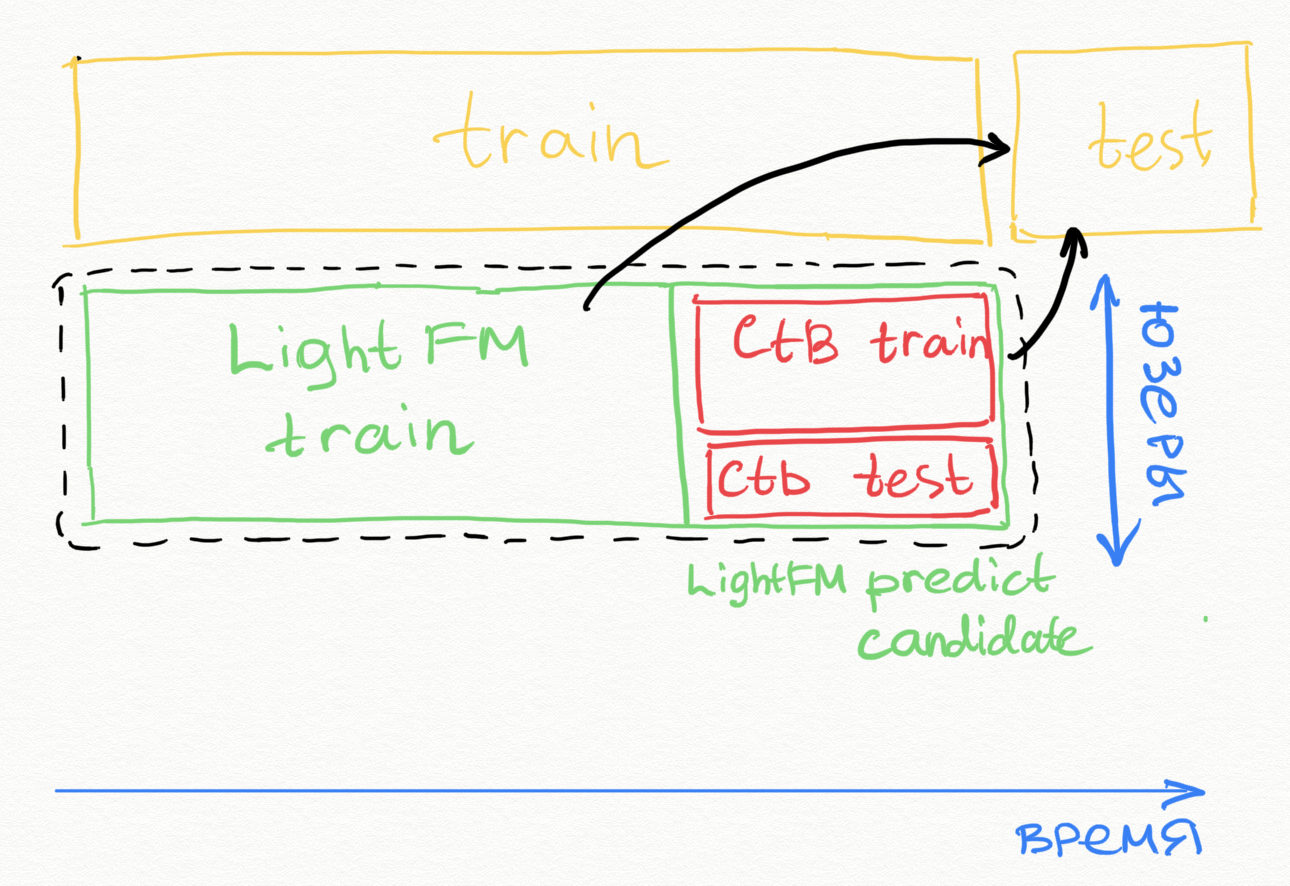
**Глобальный `train` - `test`**

На `test` оставим 21 день и будем проверять результат обеих моделей:
- модели первого этапа: `LightFM`
- модели двухэтапной: `LightFM`+`Catboost`

In [ ]:
logs = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/logs_num.csv', parse_dates=['datetime'])
movies = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/movies_num.csv')
train_movies = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/train_movies.csv')
train_users = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/train_users.csv')

In [ ]:
train_movies.info()

In [ ]:
train_movies.columns

Index(['movie_id', 'name', 'year', 'genres', 'countries', 'staff', 'actor',
       'producer', 'editor', 'director', 'writer', 'composer', 'crew',
       'year_diff', 'drtn_max', 'drtn_log_max', 'dp_timestamp',
       'description_sim', 'name_sim', 'genres_sim', 'countries_sim',
       'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim', 'director_sim',
       'writer_sim', 'composer_sim', 'crew_sim', 'uid_cnt_7_ago',
       'uid_cnt_6_ago', 'uid_cnt_5_ago', 'uid_cnt_4_ago', 'uid_cnt_3_ago',
       'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago', 'uid_cnt',
       'm_drtn_mdn', 'm_drtn_log_mdn', 'm_maxmin_ts_diff', 'm_ts_dp_diff_mdn',
       'm_prsnt_drtn_mdn', 'm_prsnt_drtn_log_mdn', 'm_woy_md', 'm_doy_md',
       'm_dom_md', 'm_dow_md', 'm_hour_md', 'm_wknd_md', 'm_frqnc'],
      dtype='object')

In [ ]:
train_movies[['name', 'genres', 'countries', 'staff', 'actor', 'producer', 'editor', 'director', 'writer', 'composer', 'crew']] = \
train_movies[['name', 'genres', 'countries', 'staff', 'actor', 'producer', 'editor', 'director', 'writer', 'composer', 'crew']].fillna('')

In [75]:
train = logs[(logs['datetime'].dt.week < logs['datetime'].dt.week.max() - 2)]
test = logs[(logs['datetime'].dt.week >= logs['datetime'].dt.week.max() - 2)]


In [ ]:
train['datetime'].dt.week.min(), train['datetime'].dt.week.max()

(14, 21)

In [ ]:
test['datetime'].dt.week.min(), test['datetime'].dt.week.max()

(22, 24)

In [ ]:
# max_date = logs['datetime'].dt.date.max()

# train = logs[(logs['datetime'].dt.date < max_date - pd.Timedelta(days=21))]
# test = logs[(logs['datetime'].dt.date >= max_date - pd.Timedelta(days=21))]


In [ ]:
print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (1230323, 13)
test: (421297, 13)


In [ ]:
movies.columns

Index(['movie_id', 'name', 'year', 'description', 'genres', 'countries',
       'staff', 'actor', 'producer', 'editor', 'director', 'writer',
       'composer', 'crew', 'year_diff', 'drtn_max', 'drtn_log_max',
       'dp_timestamp', 'description_sim', 'name_sim', 'genres_sim',
       'countries_sim', 'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim',
       'director_sim', 'writer_sim', 'composer_sim', 'crew_sim', 'uid_cnt_w14',
       'uid_cnt_w15', 'uid_cnt_w16', 'uid_cnt_w17', 'uid_cnt_w18',
       'uid_cnt_w19', 'uid_cnt_w20', 'uid_cnt_w21', 'uid_cnt_w22',
       'uid_cnt_w23', 'uid_cnt_w24'],
      dtype='object')

In [64]:
train_cols = ['movie_id', 'name', 'year', 'genres', 'countries',
       'staff', 'actor', 'producer', 'editor', 'director', 'writer',
       'composer', 'crew', 'year_diff', 'drtn_max', 'drtn_log_max',
       'dp_timestamp', 'description_sim', 'name_sim', 'genres_sim',
       'countries_sim', 'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim',
       'director_sim', 'writer_sim', 'composer_sim', 'crew_sim', 'uid_cnt_w14',
       'uid_cnt_w15', 'uid_cnt_w16', 'uid_cnt_w17', 'uid_cnt_w18',
       'uid_cnt_w19', 'uid_cnt_w20', 'uid_cnt_w21']
logs_movies = train.merge(movies[train_cols], on='movie_id', how='left')

logs_movies['ts_dp_diff'] = logs_movies['timestamp'] - logs_movies['dp_timestamp']
logs_movies['prsnt_drtn'] = logs_movies['duration'] / logs_movies['drtn_max']
logs_movies['prsnt_drtn_log'] = logs_movies['drtn_log'] / logs_movies['drtn_log_max']

In [65]:
%%time
# Группировка по user_id и вычисление необходимых статистик
train_users = logs_movies.groupby('user_id').agg({
    'movie_id': 'count',
    'duration': 'median',
    'drtn_log': 'median',
    'timestamp': lambda x: x.max() - x.min(),
    'year': lambda x: x.mode().values[0],
    'year_diff': lambda x: x.mode().values[0],
    'description_sim': 'median',
    'name_sim': 'median',
    'genres_sim': 'median',
    'countries_sim': 'median',
    'staff_sim': 'median',
    'actor_sim': 'median',
    'producer_sim': 'median',
    'editor_sim': 'median',
    'director_sim': 'median',
    'writer_sim': 'median',
    'composer_sim': 'median',
    'crew_sim': 'median',
    'ts_dp_diff': 'median',
    'prsnt_drtn': 'median',
    'prsnt_drtn_log': 'median',
    'weekofyear': lambda x: x.mode().values[0],
    'dayofyear': lambda x: x.mode().values[0],
    'day': lambda x: x.mode().values[0],
    'dayofweek': lambda x: x.mode().values[0],
    'hour': lambda x: x.mode().values[0],
    'weekend': lambda x: x.mode().values[0]
}).reset_index().rename(columns={
    'movie_id': 'mid_cnt',
    'duration': 'u_drtn_mdn',
    'drtn_log': 'u_drtn_log_mdn',
    'timestamp': 'u_maxmin_ts_diff',
    'year': 'year_md',
    'year_diff': 'year_diff_md',
    'description_sim': 'description_sim_mdn',
    'name_sim': 'name_sim_mdn',
    'genres_sim': 'genres_sim_mdn',
    'countries_sim': 'countries_sim_mdn',
    'staff_sim': 'staff_sim_mdn',
    'actor_sim': 'actor_sim_mdn',
    'producer_sim': 'producer_sim_mdn',
    'editor_sim': 'editor_sim_mdn',
    'director_sim': 'director_sim_mdn',
    'writer_sim': 'writer_sim_mdn',
    'composer_sim': 'composer_sim_mdn',
    'crew_sim': 'crew_sim_mdn',
    'ts_dp_diff': 'u_ts_dp_diff_mdn',
    'prsnt_drtn': 'u_prsnt_drtn_mdn',
    'prsnt_drtn_log': 'u_prsnt_drtn_log_mdn',
    'weekofyear': 'u_woy_md',
    'dayofyear': 'u_doy_md',
    'day': 'u_dom_md',
    'dayofweek': 'u_dow_md',
    'hour': 'u_hour_md',
    'weekend': 'u_wknd_md'
})
train_users['u_drtn_mdn'] = train_users['u_drtn_mdn'].astype(int)
train_users['u_frqnc'] = train_users['u_maxmin_ts_diff'] / train_users['mid_cnt']
train_users['u_frqnc'] = train_users['u_frqnc'].astype(int)
train_users['u_ts_dp_diff_mdn'] = train_users['u_ts_dp_diff_mdn'].astype(int)

CPU times: user 4min 29s, sys: 3.35 s, total: 4min 32s
Wall time: 4min 33s


In [66]:
gs_labs_train_users = ('/content/drive/MyDrive/colab_notebooks/gs_labs/' + 'train_users.csv')
train_users.to_csv(gs_labs_train_users, index=False)

In [67]:
%%time
# Группировка по user_id и вычисление необходимых статистик
grouped = logs_movies.groupby('movie_id').agg({
    'user_id': 'count',
    'duration': 'median',
    'drtn_log': 'median',
    'timestamp': lambda x: x.max() - x.min(),
    'ts_dp_diff': 'median',
    'prsnt_drtn': 'median',
    'prsnt_drtn_log': 'median',
    'weekofyear': lambda x: x.mode().values[0],
    'dayofyear': lambda x: x.mode().values[0],
    'day': lambda x: x.mode().values[0],
    'dayofweek': lambda x: x.mode().values[0],
    'hour': lambda x: x.mode().values[0],
    'weekend': lambda x: x.mode().values[0]
}).reset_index().rename(columns={
    'user_id': 'uid_cnt',
    'duration': 'm_drtn_mdn',
    'drtn_log': 'm_drtn_log_mdn',
    'timestamp': 'm_maxmin_ts_diff',
    'ts_dp_diff': 'm_ts_dp_diff_mdn',
    'prsnt_drtn': 'm_prsnt_drtn_mdn',
    'prsnt_drtn_log': 'm_prsnt_drtn_log_mdn',
    'weekofyear': 'm_woy_md',
    'dayofyear': 'm_doy_md',
    'day': 'm_dom_md',
    'dayofweek': 'm_dow_md',
    'hour': 'm_hour_md',
    'weekend': 'm_wknd_md'
})
grouped['m_drtn_mdn'] = grouped['m_drtn_mdn'].astype(int)
grouped['m_frqnc'] = grouped['m_maxmin_ts_diff'] / grouped['uid_cnt']
grouped['m_frqnc'] = grouped['m_frqnc'].astype(int)
grouped['m_ts_dp_diff_mdn'] = grouped['m_ts_dp_diff_mdn'].astype(int)

train_movies = movies[train_cols].merge(grouped, on='movie_id', how='left')

CPU times: user 8.2 s, sys: 126 ms, total: 8.32 s
Wall time: 8.61 s


In [68]:
train_movies.rename(columns={'uid_cnt_w14': 'uid_cnt_7_ago',
                             'uid_cnt_w15': 'uid_cnt_6_ago',
                             'uid_cnt_w16': 'uid_cnt_5_ago',
                             'uid_cnt_w17': 'uid_cnt_4_ago',
                             'uid_cnt_w18': 'uid_cnt_3_ago',
                             'uid_cnt_w19': 'uid_cnt_2_ago',
                             'uid_cnt_w20': 'uid_cnt_1_ago',
                             'uid_cnt_w21': 'uid_cnt_0_ago'}, inplace=True)

In [69]:
gs_labs_train_movies = ('/content/drive/MyDrive/colab_notebooks/gs_labs/' + 'train_movies.csv')
train_movies.to_csv(gs_labs_train_movies, index=False)

In [70]:
del logs_movies

## **1️⃣ 1 этап: `LightFM` - user2item модель**

- обучаем `LightFM` на `LighFM` `train`
- делаем предикт c кандидатами на `LighFM` `predict`

**Разделим данные для `LightFM` еще на 2 части: `train` + `pred` for candidates**

Разделим данные на `lfm_train` и `lfm_pred` как 60%-40% по квантилю даты просмотра

(Считаем, что гиперпараметры оптимальной `LightFM` модели мы уже подобрали)

На `lfm_pred` будем в дальнейшем обучать `Catboost` - модель второго этапа

In [ ]:
lfm_train = train[(train['datetime'].dt.week < train['datetime'].dt.week.max() - 2)]
lfm_pred = train[(train['datetime'].dt.week >= train['datetime'].dt.week.max() - 2)]


In [ ]:
lfm_train['datetime'].dt.week.min(), lfm_train['datetime'].dt.week.max()

(14, 18)

In [ ]:
lfm_pred['datetime'].dt.week.min(), lfm_pred['datetime'].dt.week.max()

(19, 21)

In [ ]:
# date_threshold = train['datetime'].quantile(q=0.6, interpolation='nearest')

# lfm_train = train[(train['datetime'] < date_threshold)]
# lfm_pred = train[(train['datetime'] >= date_threshold)]


In [ ]:
print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (766078, 13)
lfm_pred: (464245, 13)


In [ ]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]


In [ ]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['movie_id'].unique())

interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'movie_id', 'duration']].values.T))

weights_matrix_csr = weights_matrix.tocsr()

lightfm_mapping = dataset.mapping()
lightfm_mapping = {'users_mapping': lightfm_mapping[0], 'items_mapping': lightfm_mapping[2]}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}


### **Подбор гиперпараметров `LightFM`**

https://making.lyst.com/lightfm/docs/index.html

In [ ]:
!pip install optuna

In [ ]:
# import optuna
# from lightfm import LightFM
# from lightfm.evaluation import precision_at_k
# from lightfm.data import Dataset

# # Загрузка данных
# data = pd.read_csv('logs.csv')

# # Создание экземпляра Dataset
# dataset = Dataset()

# # Создание пользовательского идентификатора
# dataset.fit((user_id for user_id in data['user_id']),
#             (movie_id for movie_id in data['movie_id']))

# # Создание разреженной матрицы взаимодействий
# (interactions, _) = dataset.build_interactions((
#     (user_id, movie_id) for user_id, movie_id in zip(data['user_id'], data['movie_id'])))

# # Функция для оптимизации
# def objective(trial):
#     # Определение гиперпараметров для оптимизации
#     num_components = trial.suggest_int('num_components', 10, 100)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
#     # Создание модели LightFM с определенными гиперпараметрами
#     model = LightFM(no_components=num_components, learning_rate=learning_rate)
#     # Обучение модели
#     model.fit(interactions, epochs=10)
#     # Вычисление метрики precision@k на валидационном наборе данных
#     precision = precision_at_k(model, interactions, k=20).mean()
#     # Возврат значения метрики для оптимизации
#     return precision

# # Создание экземпляра Study
# study = optuna.create_study(direction='maximize')
# # Запуск оптимизации
# study.optimize(objective, n_trials=100)

# # Вывод результатов оптимизации
# print('Best parameters:', study.best_params)
# print('Best precision@k:', study.best_value)

In [ ]:
# import pandas as pd
# import lightfm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from optuna import create_study, Trial

# df = pd.read_csv('logs.csv')

# train, test = train_test_split(df, test_size=0.2, random_state=42)

# def objective(trial):
#     model = lightfm.LightFM(learning_rate=trial.suggest_loguniform('learning_rate', 1e-6, 1e-1),
#                             num_threads=trial.suggest_int('num_threads', 1, 4),
#                             item_alpha=trial.suggest_loguniform('item_alpha', 1e-6, 1e-1),
#                             item_beta=trial.suggest_loguniform('item_beta', 1e-6, 1e-1),
#                             user_alpha=trial.suggest_loguniform('user_alpha', 1e-6, 1e-1),
#                             user_beta=trial.suggest_loguniform('user_beta', 1e-6, 1e-1))

#     model.fit(train['user_id'], train['movie_id'], epochs=50, num_threads=4)

#     train_predictions = model.predict(train['user_id'], train['movie_id'])
#     test_predictions = model.predict(test['user_id'], test['movie_id'])

#     train_rmse = mean_squared_error(train['duration'], train_predictions) ** 0.5
#     test_rmse = mean_squared_error(test['duration'], test_predictions) ** 0.5

#     return test_rmse

# study = create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best trial:', study.best_trial.params)
# print('Best value:', study.best_value)

In [ ]:
import optuna
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split

# Importing other necessary libraries and loading your data into lfm_train.
# Please ensure that "Dataset" and "lfm_train" are properly defined as shown in your earlier steps.

# Define the objective function for optimization
def objective(trial):
    # Define the hyperparameters to be optimized
    no_components = trial.suggest_categorical('no_components', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    loss_function = 'warp'
    max_sampled = trial.suggest_int('max_sampled', 5, 15)

    # Create and train the LightFM model using these hyperparameters
    model = LightFM(
        no_components=no_components,
        learning_rate=learning_rate,
        loss=loss_function,
        max_sampled=max_sampled,
        random_state=42
    )

    # We'll use a simple train-test split for evaluating the model's performance
    train_interactions, test_interactions = random_train_test_split(
        weights_matrix_csr, test_percentage=0.2, random_state=42)

    # Train the model, consider using more epochs in a real scenario
    model.fit(train_interactions, epochs=20, num_threads=1)

    # Evaluate the model's performance using precision@k on the test set
    # Consider using a different metric depending on your problem
    test_precision = precision_at_k(model, test_interactions, k=20).mean()

    # Return the score
    return test_precision

# Create a study object and specify the direction is 'maximize' since we want to maximize precision@k
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=50)  # Specify the number of trials

# Best hyperparameters
print('Best hyperparameters:', study.best_params)

# We can access the best model as follows
# best_model = LightFM(**study.best_params)

[I 2024-01-31 07:00:11,910] A new study created in memory with name: no-name-8e030b2f-0f4b-458b-b993-a49e23351531
[I 2024-01-31 07:02:18,651] Trial 0 finished with value: 0.01843418926000595 and parameters: {'no_components': 64, 'learning_rate': 0.029333301949286347, 'max_sampled': 6}. Best is trial 0 with value: 0.01843418926000595.
[I 2024-01-31 07:05:25,736] Trial 1 finished with value: 0.012469572015106678 and parameters: {'no_components': 128, 'learning_rate': 0.06615176973999595, 'max_sampled': 9}. Best is trial 0 with value: 0.01843418926000595.
[I 2024-01-31 07:08:37,290] Trial 2 finished with value: 0.01364714652299881 and parameters: {'no_components': 128, 'learning_rate': 0.05324964637502215, 'max_sampled': 10}. Best is trial 0 with value: 0.01843418926000595.
[I 2024-01-31 07:10:36,351] Trial 3 finished with value: 0.017425617203116417 and parameters: {'no_components': 64, 'learning_rate': 0.015500996701312053, 'max_sampled': 15}. Best is trial 0 with value: 0.0184341892600

Best hyperparameters: {'no_components': 64, 'learning_rate': 0.02626257638432443, 'max_sampled': 15}


Best hyperparameters: {'no_components': 64, 'learning_rate': 0.017522305171320484, 'loss': 'warp', 'max_sampled': 11}

### **Обучение `LightFM`**

In [ ]:
%%time
lfm_params = {
    'no_components': 64,
    'learning_rate': 0.01,
    'max_sampled': 5,
    'loss': 'warp',
    'random_state': 42
    }
lfm_model = LightFM(**lfm_params)

num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr)


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2min 7s, sys: 482 ms, total: 2min 7s
Wall time: 2min 24s


**Генерируем предсказания `LightFM` как кандидатов для второго этапа**

In [ ]:
%%time
# кол-во кандидатов
top_N = 30

# вспомогательные данные
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

# генерируем предказания
candidates = pd.DataFrame({'user_id': lfm_pred['user_id'].unique()})
candidates['movie_id'] = candidates['user_id'].map(mapper)


CPU times: user 2min 54s, sys: 13.3 s, total: 3min 8s
Wall time: 2min 42s




---



In [ ]:
#
candidates = candidates.explode('movie_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1




---

## **2️⃣ 2 этап: обучаем CatBoost (без дополнительных признаков)**

- Ставим задачу как бинарную классификацию
- Выбираем CatBoostClassifier, так как много категориальных признаков

Собираем train + target

📗 target = 1 Позитивные взаимодействия = все что пользователь посмотрел из кандидатов lightfm

In [ ]:
# Позитивные взаимодействия
pos = candidates.merge(lfm_pred, on=['user_id', 'movie_id'], how='inner')
pos['target'] = 1


📕 target = 0 Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов lightfm
- добавим сэмплирование, чтобы соблюсти баланс классов

In [ ]:
# Негативные взаимодействия
neg = candidates.set_index(['user_id', 'movie_id']).join(lfm_pred.set_index(['user_id', 'movie_id']))
neg = neg[neg['duration'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0


Формируем трейн и тест: ctb_train, ctb_test

Важно! Делим по пользователям, а не по дате.

Мотивация:
- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [ ]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                   random_state=42,
                                                   test_size=0.2)
# 10% под early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                   random_state=42,
                                                   test_size=0.1)


In [ ]:
select_col = ['user_id', 'movie_id', 'rank', 'target']
# Catboost train
ctb_train = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_train_users)],
                               neg[neg['user_id'].isin(ctb_train_users)]])[select_col])
# Catboost test
ctb_test = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_test_users)],
                              neg[neg['user_id'].isin(ctb_test_users)]])[select_col])
# for early stopping
ctb_eval = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_eval_users)],
                              neg[neg['user_id'].isin(ctb_eval_users)]])[select_col])


Проверяем баланс классов

In [ ]:
ctb_train['target'].value_counts(normalize=True)

0    0.727167
1    0.272833
Name: target, dtype: float64

In [ ]:
ctb_test['target'].value_counts(normalize=True)

0    0.728355
1    0.271645
Name: target, dtype: float64

Формируем фичи
- в этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- как признак также используем rank от модели 1 этапа
- заполняем пропуски в данных

In [ ]:
movies.columns

Index(['movie_id', 'name', 'year', 'description', 'genres', 'countries',
       'staff', 'actor', 'producer', 'editor', 'director', 'writer',
       'composer', 'year_diff', 'dp_timestamp', 'crew'],
      dtype='object')

In [ ]:
item_col = ['movie_id', 'year', 'genres', 'countries', 'staff', 'actor', 'producer',
            'editor', 'director', 'writer', 'composer', 'year_diff', 'dp_timestamp', 'crew']

train_feat = ctb_train.merge(movies[item_col], on=['movie_id'], how='left')

eval_feat = ctb_eval.merge(movies[item_col], on=['movie_id'], how='left')


X, y

In [ ]:
drop_col = ['user_id', 'movie_id']
target_col = ['target']
cat_col = ['year', 'genres', 'countries', 'staff', 'actor', 'producer', 'editor',
           'director', 'writer', 'composer', 'crew']

X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]


### **Обучаем `CatBoostClassifier`**

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке

In [ ]:
%%time
est_params = {
  'bootstrap_type': 'Bernoulli',
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 4000,
  'learning_rate': 0.05,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}
ctb_model = CatBoostClassifier(**est_params)

ctb_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,
    cat_features=cat_col,
    plot=False
)

0:	learn: 0.6779450	test: 0.6774516	best: 0.6774516 (0)	total: 669ms	remaining: 44m 35s
200:	learn: 0.5013243	test: 0.4954935	best: 0.4954935 (200)	total: 50.8s	remaining: 15m 59s
400:	learn: 0.4980369	test: 0.4933740	best: 0.4933740 (400)	total: 1m 49s	remaining: 16m 23s
600:	learn: 0.4962771	test: 0.4927693	best: 0.4927693 (600)	total: 2m 43s	remaining: 15m 26s
800:	learn: 0.4948620	test: 0.4924928	best: 0.4924856 (793)	total: 3m 41s	remaining: 14m 43s
1000:	learn: 0.4936288	test: 0.4924433	best: 0.4924018 (964)	total: 4m 37s	remaining: 13m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4924017879
bestIteration = 964

Shrink model to first 965 iterations.
CPU times: user 7min 59s, sys: 5.22 s, total: 8min 4s
Wall time: 4min 57s


In [ ]:
# # параметры для обучения
# est_params = {
#   'subsample': 0.9,
#   'max_depth': 5,
#   'n_estimators': 2000,
#   'learning_rate': 0.01,
#   'thread_count': 20,
#   'random_state': 42,
#   'verbose': 200,
# }
# ctb_model = CatBoostClassifier(**est_params)

# ctb_model.fit(X_train,
#               y_train,
#               eval_set=(X_val, y_val),
#               early_stopping_rounds=100,
#               cat_features=cat_col,
#               plot=True)


### **Посмотрим на `shap` `feature importance`**

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train,
                                                     y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs,
                                                    y_train_subs,
                                                    cat_features=cat_col), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

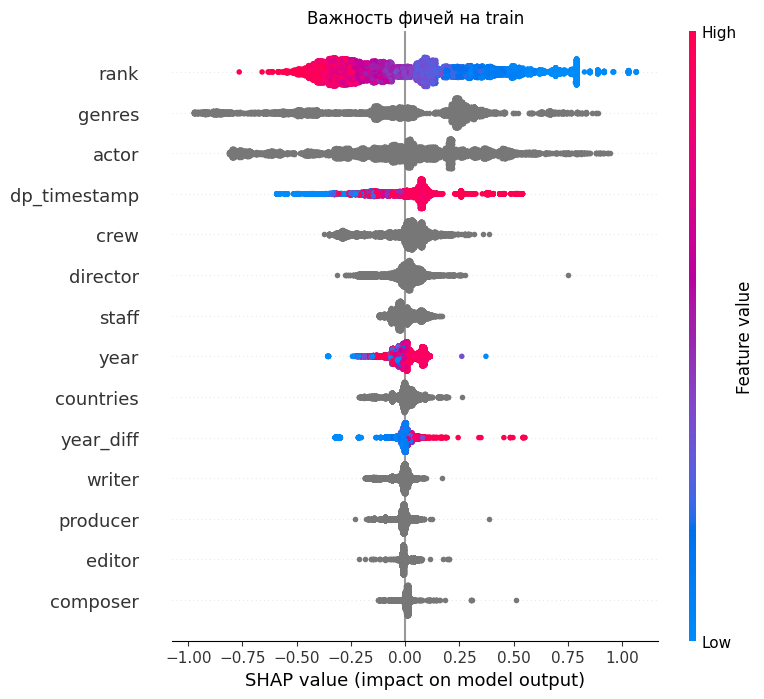

In [ ]:
plt.title("Важность фичей на train")
shap.summary_plot(shap_values, X_train_subs)

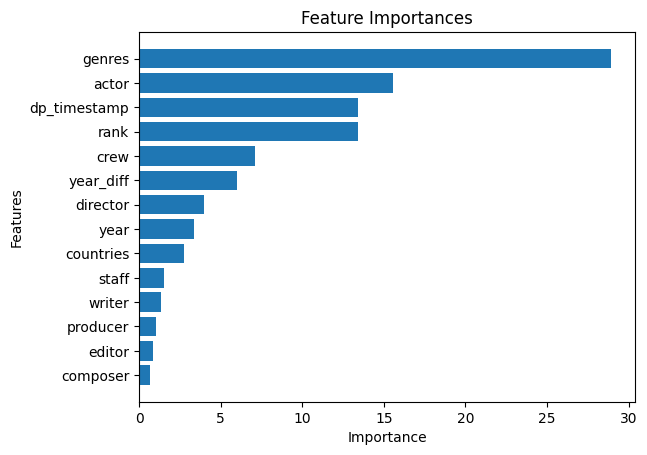

In [ ]:
feature_names = X_train.columns.to_list()
#
feature_importances = ctb_model.feature_importances_

# Сортировка значимости по убыванию
sorted_indices = feature_importances.argsort()[::1]
sorted_importances = feature_importances[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a horizontal bar plot of the feature importances
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

### **Оценим метрики `catboost` модели**

In [ ]:
test_feat = ctb_test.merge(movies[item_col], on=['movie_id'], how='left')
test_feat.head()

user_id movie_id  rank  target  year  \
0    45549     2606    17       0  2019   
1    23638     4991    30       1  2021   
2    10330     1521     3       0  2022   
3    23149     5559    16       0  2021   
4   109803     2893     3       0  2022   

                                              genres             countries  \
0                                        фильм драма                   сша   
1                        комедия приключения фэнтези                   сша   
2  комедия фантастика мультипликационный фильм се...                   сша   
3                       драма приключения фантастика  венгрия, канада, сша   
4                                      драма триллер     дания, нидерланды   

                                               staff  \
0  ДжессХолл ШарлоттаБатлер ДжимонХунсу ДайанЛэйн...   
1  ЭмилиБлант ДжессиПлемонс ЭдгарРамирес ДэвидЛен...   
2  РасселлБрэнд ПьерКоффан ДжонатандельВаль КайлБ...   
3  РебеккаФергюсон ТимотиШаламе ОскарАйзек ДениВи...   
4  МариусДамслев КристианТафдруп ДжесперДюпон Фед...   

                                               actor  \
0  ЭннХэтэуэй ДжимонХунсу ДэвидБатлер МайклРичард...   
1  ЭдгарРамирес ЭмилиБлант ДэвидЛенгел ДжессиПлем...   
2  ТараджиП.Хенсон СтивКарелл ПьерКоффан ДжулиЭнд...   
3  ТимотиШаламе ОскарАйзек РебеккаФергюсон ДжошБр...   
4  АдрианБланшар МариусДамслев ИшемЯкуби ДжесперД...   

                        producer     editor  \
0  СтивенНайт ГрегШапиро ГайХили  ДжессХолл   
1                                             
2                                             
3                                             
4                                             

                                 director      writer          composer  \
0                              СтивенНайт  СтивенНайт  БенджаминУоллфиш   
1                       ЖаумеКольет-Серра                                 
2  КайлБалда ДжонатандельВаль БрэдЭблесон                                 
3                             ДениВильнев                                 
4                         КристианТафдруп                                 

   year_diff  dp_timestamp                                               crew  
0          4    1605571200  ДжессХолл ГайХили БенджаминУоллфиш ГрегШапиро ...  
1          2    1673481600                                  ЖаумеКольет-Серра  
2          1    1680134400             ДжонатандельВаль БрэдЭблесон КайлБалда  
3          2    1673481600                                        ДениВильнев  
4          1    1674777600                                    КристианТафдруп

In [ ]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']
X_test.head()

rank  year                                             genres  \
0    17  2019                                        фильм драма   
1    30  2021                        комедия приключения фэнтези   
2     3  2022  комедия фантастика мультипликационный фильм се...   
3    16  2021                       драма приключения фантастика   
4     3  2022                                      драма триллер   

              countries                                              staff  \
0                   сша  ДжессХолл ШарлоттаБатлер ДжимонХунсу ДайанЛэйн...   
1                   сша  ЭмилиБлант ДжессиПлемонс ЭдгарРамирес ДэвидЛен...   
2                   сша  РасселлБрэнд ПьерКоффан ДжонатандельВаль КайлБ...   
3  венгрия, канада, сша  РебеккаФергюсон ТимотиШаламе ОскарАйзек ДениВи...   
4     дания, нидерланды  МариусДамслев КристианТафдруп ДжесперДюпон Фед...   

                                               actor  \
0  ЭннХэтэуэй ДжимонХунсу ДэвидБатлер МайклРичард...   
1  ЭдгарРамирес ЭмилиБлант ДэвидЛенгел ДжессиПлем...   
2  ТараджиП.Хенсон СтивКарелл ПьерКоффан ДжулиЭнд...   
3  ТимотиШаламе ОскарАйзек РебеккаФергюсон ДжошБр...   
4  АдрианБланшар МариусДамслев ИшемЯкуби ДжесперД...   

                        producer     editor  \
0  СтивенНайт ГрегШапиро ГайХили  ДжессХолл   
1                                             
2                                             
3                                             
4                                             

                                 director      writer          composer  \
0                              СтивенНайт  СтивенНайт  БенджаминУоллфиш   
1                       ЖаумеКольет-Серра                                 
2  КайлБалда ДжонатандельВаль БрэдЭблесон                                 
3                             ДениВильнев                                 
4                         КристианТафдруп                                 

   year_diff  dp_timestamp                                               crew  
0          4    1605571200  ДжессХолл ГайХили БенджаминУоллфиш ГрегШапиро ...  
1          2    1673481600                                  ЖаумеКольет-Серра  
2          1    1680134400             ДжонатандельВаль БрэдЭблесон КайлБалда  
3          2    1673481600                                        ДениВильнев  
4          1    1674777600                                    КристианТафдруп

In [ ]:
y_pred = ctb_model.predict_proba(X_test)


In [ ]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.72'

Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost
- Сравниваем

1) Метрики качества LightFM

In [ ]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]


In [ ]:
%%time
top_N = 200

lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)


CPU times: user 3min 22s, sys: 16.9 s, total: 3min 38s
Wall time: 3min 19s


In [ ]:
lfm_prediction

user_id                                           movie_id
0           23  [2461, 7081, 2606, 6336, 90, 6907, 7073, 4901,...
1        10049  [4687, 1521, 1979, 5287, 158, 1066, 65, 3859, ...
2         4247  [4090, 5336, 6194, 3152, 484, 2679, 4205, 5256...
3        47842  [484, 5336, 6194, 5712, 2679, 4090, 4314, 2893...
4        12078  [5336, 5712, 6091, 2893, 4314, 1281, 1744, 584...
...        ...                                                ...
51720    78826  [484, 2679, 6091, 5336, 4314, 2074, 2893, 5876...
51721    75591  [484, 6194, 5336, 2893, 6091, 4090, 2679, 2074...
51722   125260  [484, 3728, 2820, 1226, 2893, 4314, 6194, 451,...
51723   112352  [484, 4687, 1979, 3728, 158, 5287, 65, 451, 38...
51724    94076  [484, 4687, 3728, 1521, 451, 1979, 158, 2480, ...

[51725 rows x 2 columns]

In [ ]:
lfm_prediction = lfm_prediction.explode('movie_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1

1 этап LightFM: Метрики Precision@k, Recall@k, MAP@k, MRR

k = 1, .., 20

In [ ]:
lfm_metrics = compute_metrics(test[['user_id', 'movie_id']],
                              lfm_prediction,
                              top_N=20)
lfm_metrics

Precision@5     0.024882
Recall@5        0.029367
Precision@10    0.023035
Recall@10       0.051561
Precision@15    0.020728
Recall@15       0.067362
Precision@20    0.019082
Recall@20       0.079927
MAP@20          0.031930
MRR             0.082812
dtype: float64

MAP@20          0.031976

MRR             0.098171

2) Метрики качества двухэтапной модели: LightFM + Catboost

In [ ]:
lfm_ctb_prediction = lfm_prediction.copy()

score_feat = lfm_ctb_prediction.merge(movies[item_col], on=['movie_id'], how='left')


In [ ]:
%%time
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]


CPU times: user 1min 37s, sys: 2.46 s, total: 1min 39s
Wall time: 1min 16s


In [ ]:
lfm_ctb_prediction

user_id movie_id  rank  ctb_pred
0              23     2461     1  0.056651
1              23     7081     2  0.044617
2              23     2606     3  0.130080
3              23     6336     4  0.226734
4              23       90     5  0.121060
...           ...      ...   ...       ...
10344995    94076     6150   196  0.091044
10344996    94076     2447   197  0.189760
10344997    94076     1309   198  0.403255
10344998    94076     4598   199  0.497262
10344999    94076     4991   200  0.346540

[10345000 rows x 4 columns]

Проставляем итоговый ранк двухэтапной модели

In [ ]:
%%time
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1


In [ ]:
lfm_ctb_prediction

user_id movie_id  rank  ctb_pred  rank_ctb
3239668        0     6563    69  0.652585         1
3239682        0     3193    83  0.591145         2
3239631        0     3856    32  0.588089         3
3239786        0      405   187  0.562826         4
3239693        0     6615    94  0.545443         5
...          ...      ...   ...       ...       ...
7138429   176532     5276    30  0.020446       196
7138417   176532     7261    18  0.019646       197
7138432   176532     7081    33  0.018544       198
7138549   176532     4314   150  0.015635       199
7138402   176532     4772     3  0.014119       200

[10345000 rows x 5 columns]

In [ ]:
# интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 20]['rank'],
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 20]['rank_ctb']) \
    .style.background_gradient(cmap='spring')

1+2 этапы LightFM + Сatboost: Метрики

k = 1, .., 20

In [ ]:
model_2step_metrics = compute_metrics(test[['user_id', 'movie_id']],
                                      lfm_ctb_prediction,
                                      top_N=20,
                                      rank_col='rank_ctb')
model_2step_metrics

Precision@5     0.020806
Recall@5        0.020872
Precision@10    0.019998
Recall@10       0.041535
Precision@15    0.017958
Recall@15       0.054069
Precision@20    0.016914
Recall@20       0.066261
MAP@20          0.023094
MRR             0.063119
dtype: float64

MAP@20          0.028746

MRR             0.096577

🧐 Сравнение метрик

In [ ]:
df_metrics = pd.concat([pd.DataFrame(lfm_metrics).transpose(),
                        pd.DataFrame(model_2step_metrics).transpose()])

df_metrics.index = ['lightfm', 'model_2step']
df_metrics

Precision@5  Recall@5  Precision@10  Recall@10  Precision@15  \
lightfm         0.024882  0.029367      0.023035   0.051561      0.020728   
model_2step     0.020806  0.020872      0.019998   0.041535      0.017958   

             Recall@15  Precision@20  Recall@20    MAP@20       MRR  
lightfm       0.067362      0.019082   0.079927  0.031930  0.082812  
model_2step   0.054069      0.016914   0.066261  0.023094  0.063119

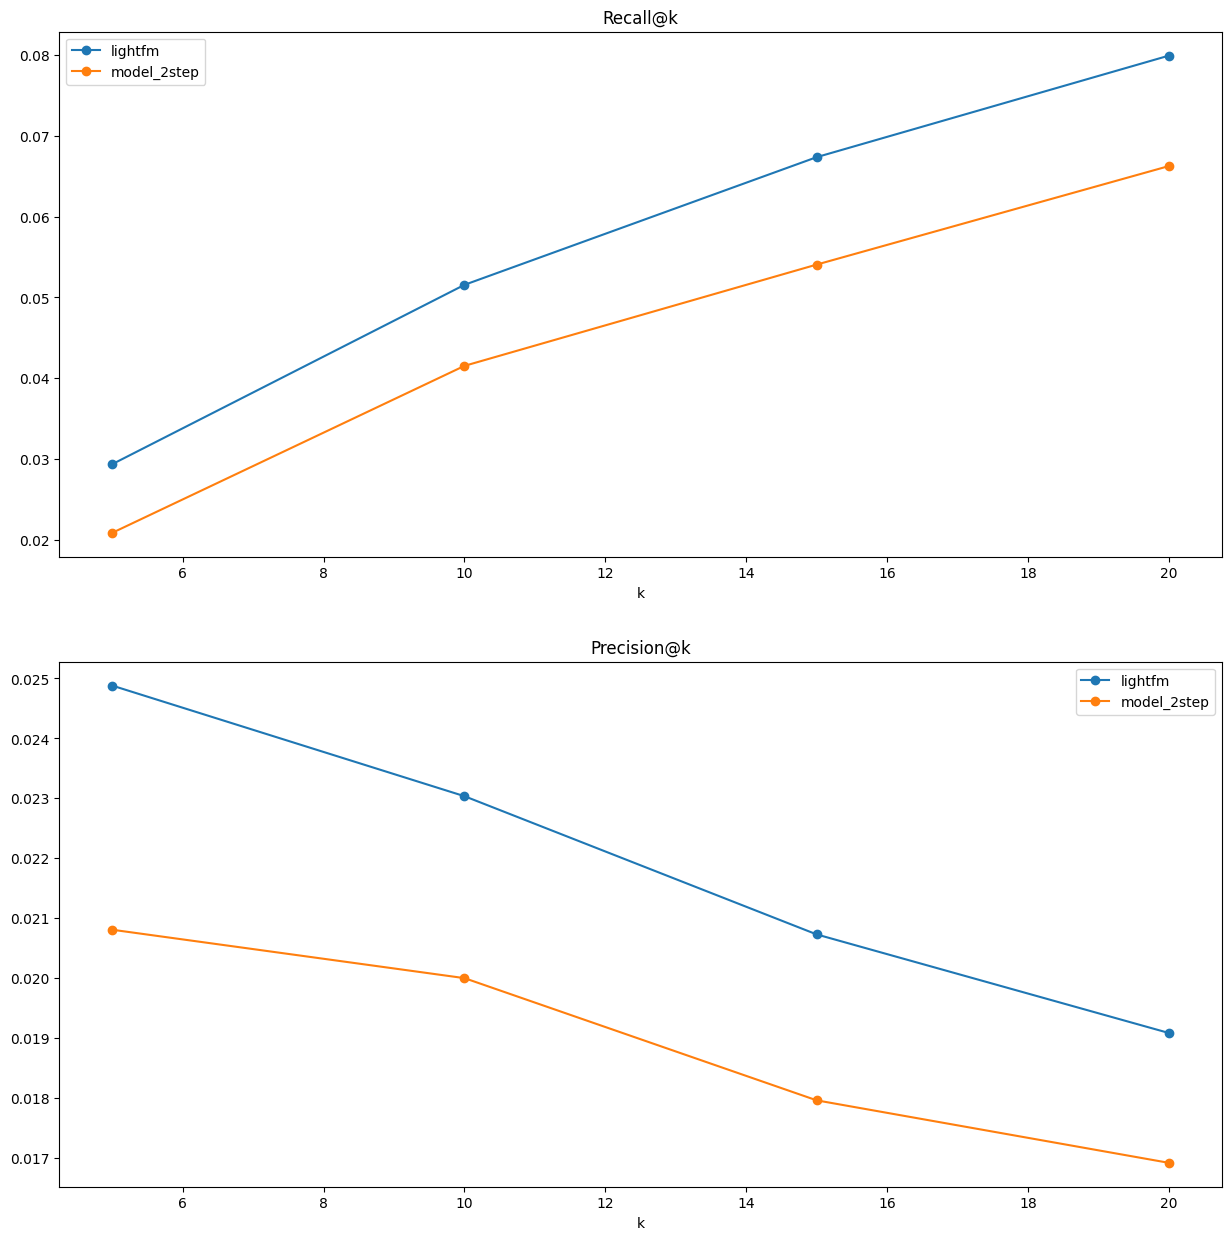

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(5, 21, 5),
                        df_metrics.loc[model][[metric+f'{k}' for k in range(5, 21, 5)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')



---

## **2️⃣ 2 этап: обучаем CatBoost (с дополнительными признаками)**

- Ставим задачу как бинарную классификацию
- Выбираем CatBoostClassifier, так как много категориальных признаков

Собираем train + target

📗 target = 1 Позитивные взаимодействия = все что пользователь посмотрел из кандидатов lightfm

In [ ]:
# Позитивные взаимодействия
pos = candidates.merge(lfm_pred, on=['user_id', 'movie_id'], how='inner')
pos['target'] = 1


📕 target = 0 Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов lightfm
- добавим сэмплирование, чтобы соблюсти баланс классов

In [ ]:
# Негативные взаимодействия
neg = candidates.set_index(['user_id', 'movie_id']).join(lfm_pred.set_index(['user_id', 'movie_id']))
neg = neg[neg['duration'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0


Формируем трейн и тест: ctb_train, ctb_test

Важно! Делим по пользователям, а не по дате.

Мотивация:
- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [ ]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                   random_state=42,
                                                   test_size=0.2)
# 10% под early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                   random_state=42,
                                                   test_size=0.1)


In [ ]:
select_col = ['user_id', 'movie_id', 'rank', 'target']
# Catboost train
ctb_train = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_train_users)],
                               neg[neg['user_id'].isin(ctb_train_users)]])[select_col],
                    random_state=42)
# Catboost test
ctb_test = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_test_users)],
                              neg[neg['user_id'].isin(ctb_test_users)]])[select_col],
                   random_state=42)
# for early stopping
ctb_eval = shuffle(pd.concat([pos[pos['user_id'].isin(ctb_eval_users)],
                              neg[neg['user_id'].isin(ctb_eval_users)]])[select_col],
                   random_state=42)


Проверяем баланс классов

In [ ]:
ctb_train['target'].value_counts(normalize=True)

0    0.737394
1    0.262606
Name: target, dtype: float64

In [ ]:
ctb_test['target'].value_counts(normalize=True)

0    0.733272
1    0.266728
Name: target, dtype: float64

Формируем фичи
- в этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- как признак также используем rank от модели 1 этапа
- заполняем пропуски в данных

In [ ]:
train_movies.info()

In [ ]:
train_users.columns

Index(['user_id', 'mid_cnt', 'u_drtn_mdn', 'u_drtn_log_mdn',
       'u_maxmin_ts_diff', 'year_md', 'year_diff_md', 'description_sim_mdn',
       'name_sim_mdn', 'genres_sim_mdn', 'countries_sim_mdn', 'staff_sim_mdn',
       'actor_sim_mdn', 'producer_sim_mdn', 'editor_sim_mdn',
       'director_sim_mdn', 'writer_sim_mdn', 'composer_sim_mdn',
       'crew_sim_mdn', 'u_ts_dp_diff_mdn', 'u_prsnt_drtn_mdn',
       'u_prsnt_drtn_log_mdn', 'u_woy_md', 'u_doy_md', 'u_dom_md', 'u_dow_md',
       'u_hour_md', 'u_wknd_md', 'u_frqnc'],
      dtype='object')

In [ ]:
train_movies.columns

Index(['movie_id', 'name', 'year', 'genres', 'countries', 'staff', 'actor',
       'producer', 'editor', 'director', 'writer', 'composer', 'crew',
       'year_diff', 'drtn_max', 'drtn_log_max', 'dp_timestamp',
       'description_sim', 'name_sim', 'genres_sim', 'countries_sim',
       'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim', 'director_sim',
       'writer_sim', 'composer_sim', 'crew_sim', 'uid_cnt_7_ago',
       'uid_cnt_6_ago', 'uid_cnt_5_ago', 'uid_cnt_4_ago', 'uid_cnt_3_ago',
       'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago', 'uid_cnt',
       'm_drtn_mdn', 'm_drtn_log_mdn', 'm_maxmin_ts_diff', 'm_ts_dp_diff_mdn',
       'm_prsnt_drtn_mdn', 'm_prsnt_drtn_log_mdn', 'm_woy_md', 'm_doy_md',
       'm_dom_md', 'm_dow_md', 'm_hour_md', 'm_wknd_md', 'm_frqnc'],
      dtype='object')

In [ ]:
gc.collect()

0

In [ ]:
user_col = ['user_id', 'mid_cnt',
       'u_maxmin_ts_diff', 'year_md', 'year_diff_md', 'description_sim_mdn',
       'name_sim_mdn', 'genres_sim_mdn', 'countries_sim_mdn', 'staff_sim_mdn',
       'producer_sim_mdn', 'editor_sim_mdn',
       'director_sim_mdn', 'writer_sim_mdn',
       'u_ts_dp_diff_mdn', 'u_prsnt_drtn_mdn',
       'u_woy_md', 'u_dom_md', 'u_dow_md',
       'u_hour_md', 'u_wknd_md', 'u_frqnc']

item_col = ['movie_id', 'year', 'genres', 'countries',
       'staff', 'actor', 'producer', 'editor', 'director', 'writer',
       'composer', 'crew', 'drtn_max',
       'description_sim', 'name_sim', 'genres_sim',
       'countries_sim', 'staff_sim', 'producer_sim',
       'director_sim', 'writer_sim', 'composer_sim',
       'uid_cnt_7_ago', 'uid_cnt_6_ago',
       'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago',
       'm_drtn_mdn', 'm_maxmin_ts_diff',
       'm_ts_dp_diff_mdn',
       'm_woy_md', 'm_dom_md', 'm_dow_md', 'm_hour_md',
       'm_frqnc']


In [ ]:
train_feat = ctb_train.merge(train_users[user_col], on=['user_id'], how='left') \
                      .merge(train_movies[item_col], on=['movie_id'], how='left')

eval_feat = ctb_eval.merge(train_users[user_col], on=['user_id'], how='left') \
                    .merge(train_movies[item_col], on=['movie_id'], how='left')

In [ ]:
# train_feat = ctb_train.merge(movies[item_col], on=['movie_id'], how='left')

# eval_feat = ctb_eval.merge(movies[item_col], on=['movie_id'], how='left')


X, y

In [ ]:
drop_col = ['user_id', 'movie_id']
target_col = ['target']
cat_col = ['genres', 'countries', 'staff', 'actor', 'producer',
           'editor', 'director', 'writer', 'composer', 'crew']

X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]

X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]


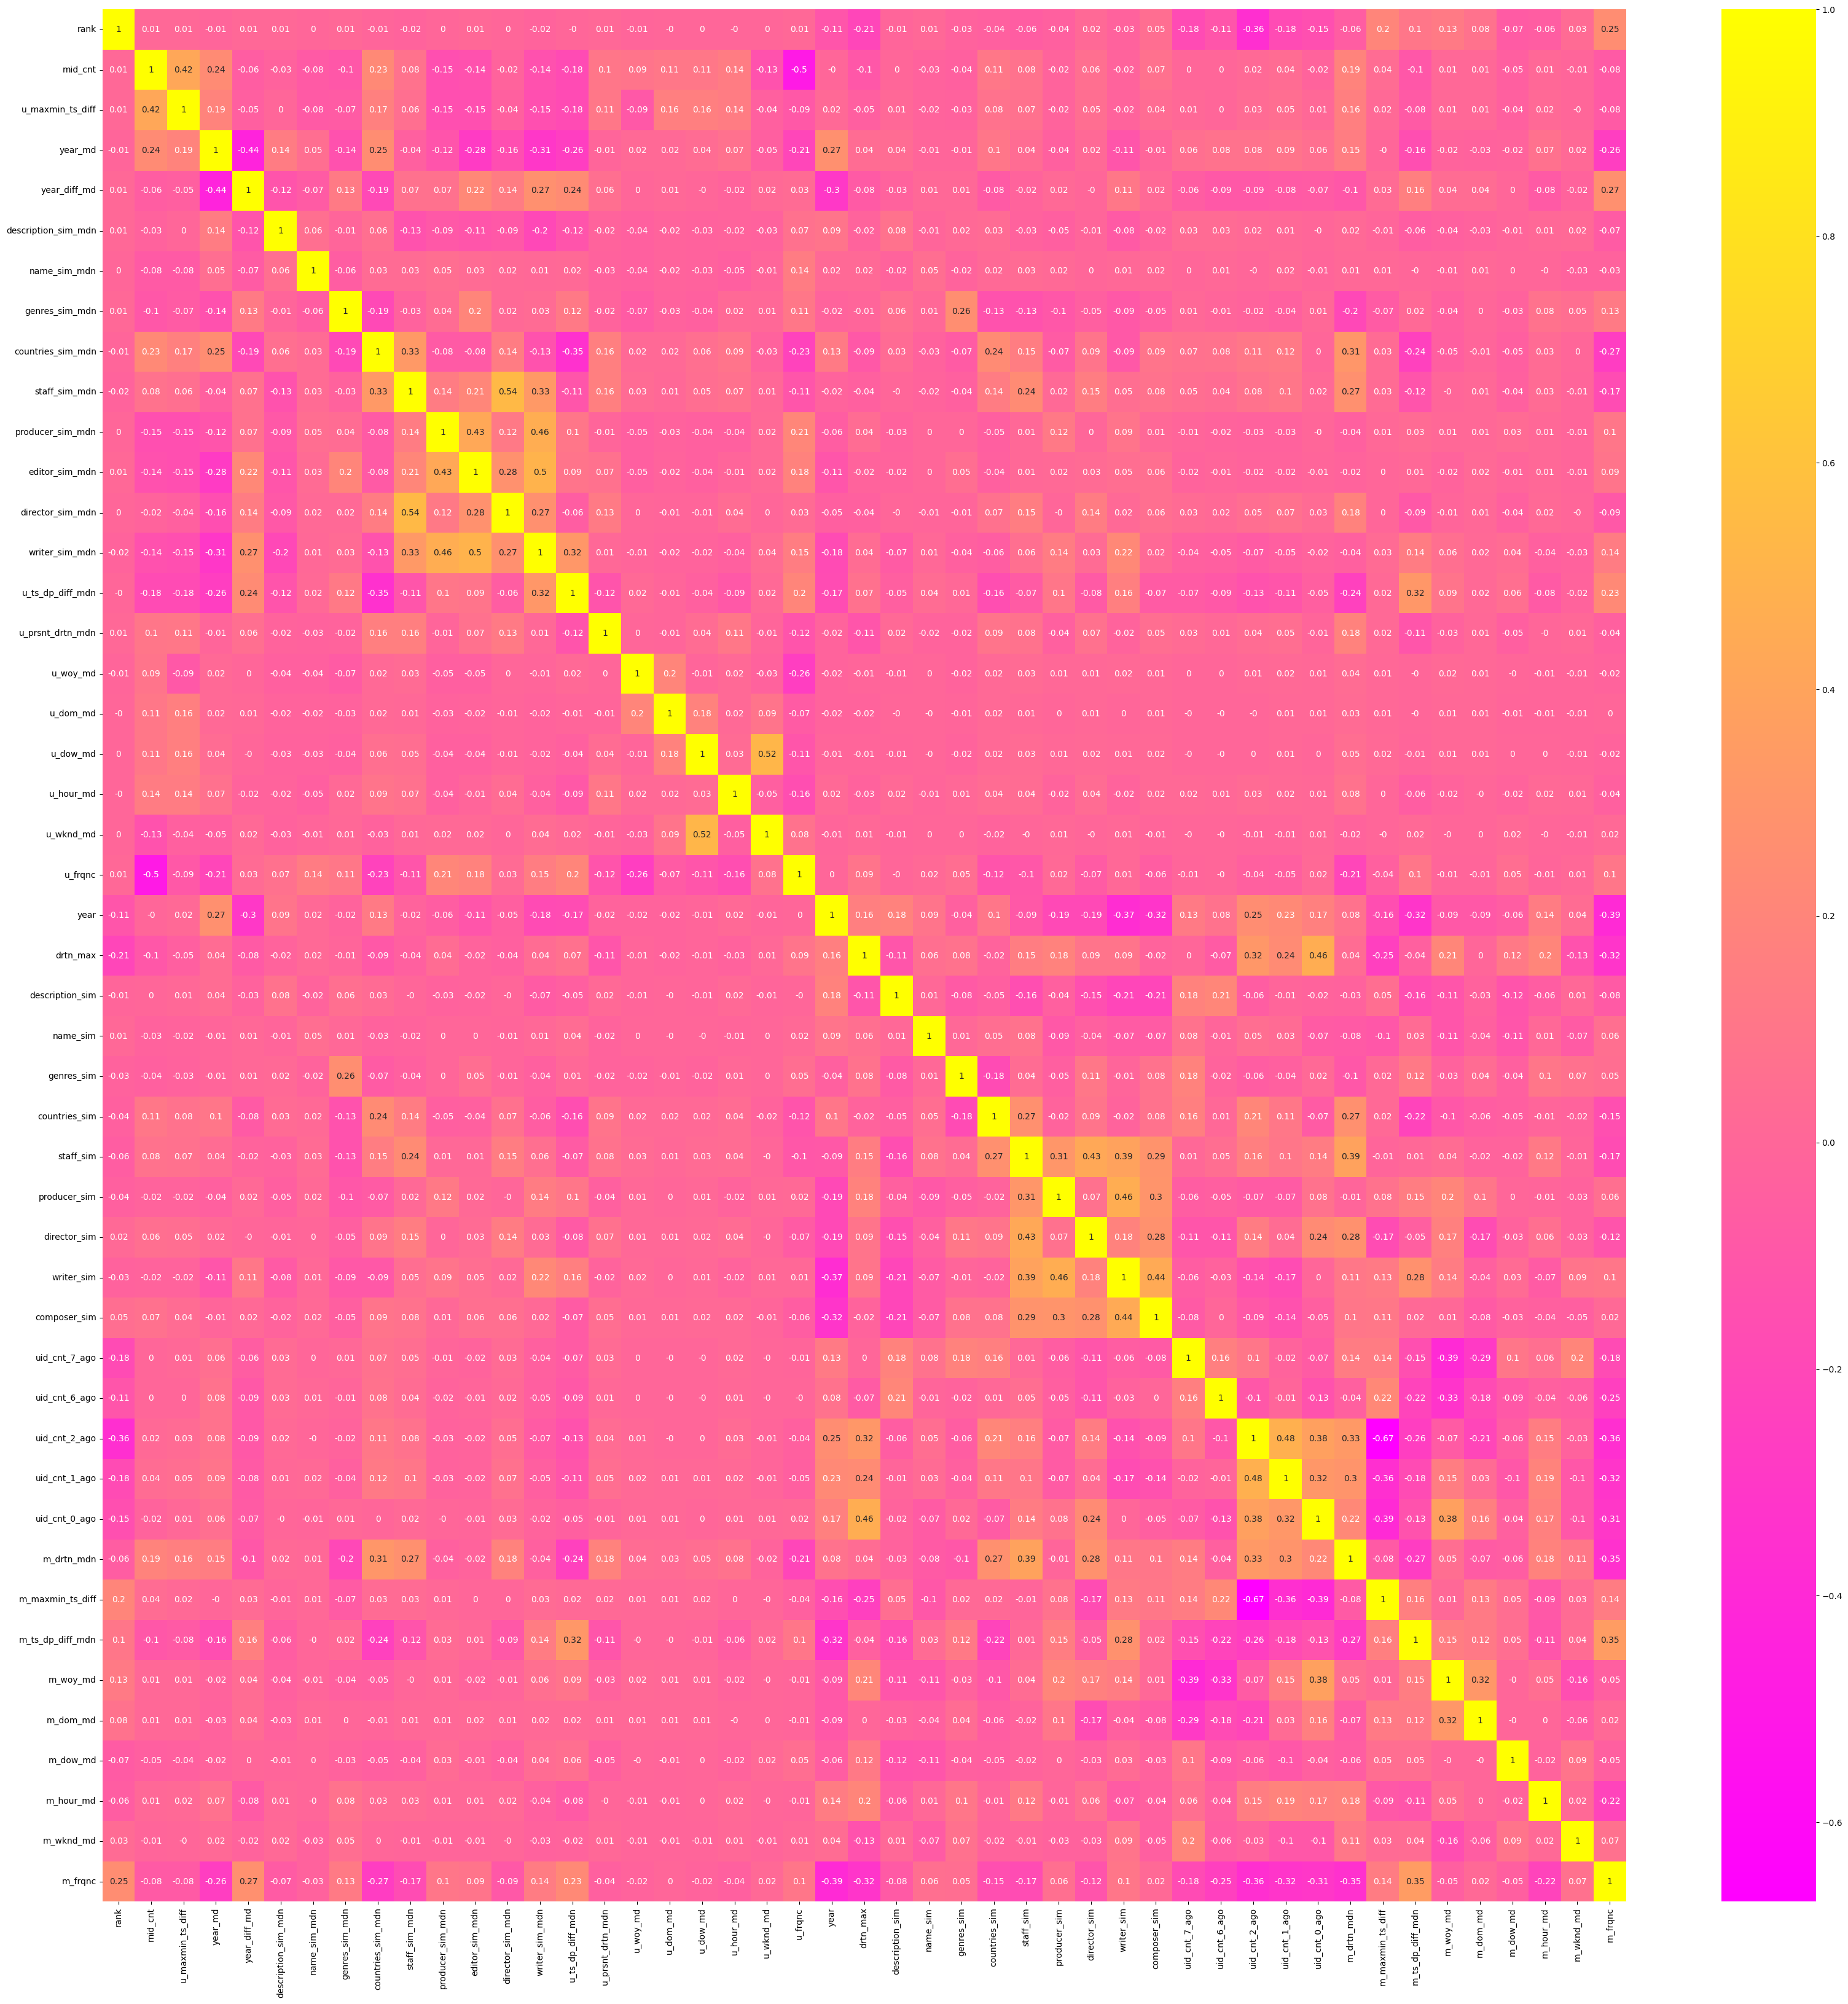

In [ ]:
import seaborn as sns

correlation_mat = X_train.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(round(correlation_mat, 2), annot=True, cmap='spring')
plt.show()

### **Подбор гиперпараметров `CatBoostClassifier`**

In [ ]:
!pip install optuna

In [ ]:
To replace the logloss metric with accuracy, you need to modify the objective function as follows:
1. Import accuracy_score from the sklearn.metrics module.
import accuracy_score from sklearn.metrics import accuracy_score
2. Replace the line `score = ctb_model.best_score_['validation']['Logloss']` with `score = accuracy_score(ctb_model.predict(X_val), y_val)`.
score = accuracy_score(ctb_model.predict(X_val), y_val) ```
# 3. Update the `study.create_study` line with `study.optimize` function with `direction='minimize'` or `'maximize'` depending on whether you want to minimize or maximize the accuracy score.
study = optuna.create_study(direction='minimize')  # or 'maximize' for accuracy, AUC, etc. ```
4. Run the script and let Optuna optimize the hyperparameters based on the new objective function. The optimized hyperparameters will be stored in the `study.best_params` dictionary. ```python
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_params)
# 5. You can also modify the `objective` function to accept the `trial` object as an argument and use its methods like `suggest_float`, `suggest_int`, etc., instead of hardcoding the hyperparameters in the `est_params` dictionary.
# This will allow Optuna to automatically suggest the best values for each hyperparameter based on the current trial's progress.
def objective(trial):
    # Defining the hyperparameters to tune
    est_params = {
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'n_estimators': trial.suggest_int('n_estimators', 1000,  10000),
        'learning_rate': trial.suggest_loguniform('learning_rate',  1e -3,  1e -1),
        'thread_count': trial.suggest_int('thread_count',  1,  40),
        'random_state':  42,
        'task_type': "GPU"
        }
# I hope this helps! Let me know if you have any further questions or concerns.

In [ ]:
import optuna
from catboost import CatBoostClassifier

# Assuming train_feat, eval_feat, drop_col, target_col, and cat_col are predefined and contain the correct values.

def objective(trial):
    # Defining the hyperparameters to tune
    est_params = {
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'thread_count': trial.suggest_int('thread_count', 1, 40),
        'random_state': 42,
        'task_type': "GPU"
    }

    # Initialize CatBoostClassifier with current set of hyperparameters
    ctb_model = CatBoostClassifier(**est_params)

    # Fit the model
    ctb_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        # cat_features=cat_col,
        verbose=False,
        plot=False
    )

    # Evaluate the model on the validation set
    # You can choose a different metric according to your problem
    score = ctb_model.best_score_['validation']['Logloss']

    return score

# We create the Optuna study, which will optimize the 'objective' function.
study = optuna.create_study(direction='minimize')  # or 'maximize' for accuracy, AUC, etc.
study.optimize(objective, n_trials=50)  # Increase n_trials for a better optimization

# Printing the best trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Best hyperparameters
print('Best hyperparameters:', study.best_params)

[I 2024-01-31 10:14:08,987] A new study created in memory with name: no-name-50c8d48f-4ba6-4100-9c52-fd7709c383c0
[I 2024-01-31 10:15:13,832] Trial 0 finished with value: 0.3885136476314003 and parameters: {'subsample': 0.7364953392146489, 'max_depth': 5, 'n_estimators': 5882, 'learning_rate': 0.007935304467816212, 'thread_count': 16}. Best is trial 0 with value: 0.3885136476314003.
[I 2024-01-31 10:17:11,617] Trial 1 finished with value: 0.3990289301905547 and parameters: {'subsample': 0.9845643874624208, 'max_depth': 8, 'n_estimators': 8817, 'learning_rate': 0.0015141123671866155, 'thread_count': 21}. Best is trial 0 with value: 0.3885136476314003.
[I 2024-01-31 10:18:09,911] Trial 2 finished with value: 0.3804453776546742 and parameters: {'subsample': 0.903093972335868, 'max_depth': 5, 'n_estimators': 8267, 'learning_rate': 0.009006002043444001, 'thread_count': 22}. Best is trial 2 with value: 0.3804453776546742.
[I 2024-01-31 10:18:28,165] Trial 3 finished with value: 0.44912298778

Number of finished trials:  50
Best trial:
  Value:  0.3727469740957137
  Params: 
    subsample: 0.9198052516546572
    max_depth: 7
    n_estimators: 4400
    learning_rate: 0.03781557943772937
    thread_count: 36
Best hyperparameters: {'subsample': 0.9198052516546572, 'max_depth': 7, 'n_estimators': 4400, 'learning_rate': 0.03781557943772937, 'thread_count': 36}


In [ ]:
# # To find the optimal hyperparameters for CatBoostClassifier using Optuna, you can follow these steps:
# # 1) Install Optuna using pip: `pip install optuna`
# # 2) Define your objective function that returns a float value representing the evaluation metric
# # (e.g., mean squared error, accuracy, or F1 score) for a given set of hyperparameters.
# # In this case, we'll use accuracy as the evaluation metric.
# # 3) Define the search space for each hyperparameter using `suggest_categorical()`, `suggest_uniform()`, or `suggest_int()`.
# # You can also define a custom distribution using `DistributionSampler`.
# # 4) Create a study object using `create_study()` and specify the objective function and search space.
# # 5) Run the study using `optimize()` and print the best hyperparameters and their values.
# # You can also save the study results to a file using `save_study()`.
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score

# def objective(trial):
#     # Define hyperparameters based on trial's suggestions
#     bootstrap_type = "Bernoulli"
#     subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
#     max_depth = trial.suggest_int("max_depth", 1, 10, step=1)
#     n_estimators = trial.suggest_int("n_estimators", 1000, 10000, step=1000)
#     learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.1)
#     thread_count = trial.suggest_int("thread_count", 2, 40, step=2)
#     random_state = 42
#     verbose = 200

#     # Create CatBoostClassifier object with suggested hyperparameters
#     model = CatBoostClassifier(
#         bootstrap_type=bootstrap_type,
#         subsample=subsample,
#         max_depth=max_depth,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         thread_count=thread_count,
#         random_state=random_state,
#         verbose=verbose,
#     )

#     # Fit the model on the training data and evaluate on the validation data
#     model.fit(X_train,
#               y_train,
#               eval_set=(X_val, y_val),
#               cat_features=cat_col)
#     val_accuracy = model.get_best_score("val")

#     # Return the evaluation metric (accuracy) as the objective function value
#     return val_accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters and their values
# print("Best hyperparameters:")
# print("bootstrap_type:", study.best_params["bootstrap_type"])
# print("subsample:", study.best_params["subsample"])
# print("max_depth:", study.best_params["max_depth"])
# print("n_estimators:", study.best_params["n_estimators"])
# print("learning_rate:", study.best_params["learning_rate"])
# print("thread_count:", study.best_params["thread_count"])
# print("random_state:", study.best_params["random_state"])
# print("verbose:", study.best_params["verbose"])

### Обучаем CatBoostClassifier

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке

In [ ]:
# {
#   'bootstrap_type': 'Bernoulli',
#   'subsample': 0.9,
#   'max_depth': 5,
#   'n_estimators': 5000,
#   'learning_rate': 0.05,
#   'thread_count': 20,
#   'random_state': 42,
#   'verbose': 200,
# }

In [ ]:
# # параметры для обучения
# est_params = {
#   'subsample': 0.9,
#   'max_depth': 5,
#   'n_estimators': 2000,
#   'learning_rate': 0.01,
#   'thread_count': 20,
#   'random_state': 42,
#   'verbose': 200,
# }
# ctb_model = CatBoostClassifier(**est_params)

# ctb_model.fit(X_train,
#               y_train,
#               eval_set=(X_val, y_val),
#               early_stopping_rounds=100,
#               cat_features=cat_col,
#               plot=True)


In [ ]:
%%time
est_params = {
    'subsample': 0.9,
    'max_depth': 5,
    'n_estimators': 5000,
    'learning_rate': 0.05,
    'thread_count': 20,
    'bootstrap_type': 'Bernoulli',
    'random_state': 42,
    'verbose': 200,
    # 'task_type': "GPU"
    }
ctb_model = CatBoostClassifier(**est_params)
ctb_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,
    cat_features=cat_col,
    plot=False
)

0:	learn: 0.6728081	test: 0.6727368	best: 0.6727368 (0)	total: 288ms	remaining: 23m 57s
200:	learn: 0.4236509	test: 0.4282888	best: 0.4282888 (200)	total: 1m	remaining: 24m
400:	learn: 0.4013625	test: 0.4091257	best: 0.4091257 (400)	total: 2m 3s	remaining: 23m 33s
600:	learn: 0.3891400	test: 0.3998873	best: 0.3998840 (599)	total: 3m 2s	remaining: 22m 18s
800:	learn: 0.3810793	test: 0.3952950	best: 0.3952950 (800)	total: 4m 1s	remaining: 21m 8s
1000:	learn: 0.3747235	test: 0.3923061	best: 0.3923061 (1000)	total: 5m 7s	remaining: 20m 29s
1200:	learn: 0.3691546	test: 0.3900743	best: 0.3900688 (1197)	total: 6m 7s	remaining: 19m 22s
1400:	learn: 0.3643222	test: 0.3883898	best: 0.3883898 (1400)	total: 7m 7s	remaining: 18m 17s
1600:	learn: 0.3598294	test: 0.3871430	best: 0.3871430 (1600)	total: 8m 7s	remaining: 17m 14s
1800:	learn: 0.3558218	test: 0.3861332	best: 0.3861332 (1800)	total: 9m 7s	remaining: 16m 12s
2000:	learn: 0.3518378	test: 0.3855638	best: 0.3855638 (2000)	total: 10m 9s	remain

### Посмотрим на shap feature importance

In [ ]:
!pip install shap

In [ ]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train,
                                                     y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs,
                                                    y_train_subs,
                                                    cat_features=cat_col
                                                    ),
                                               type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

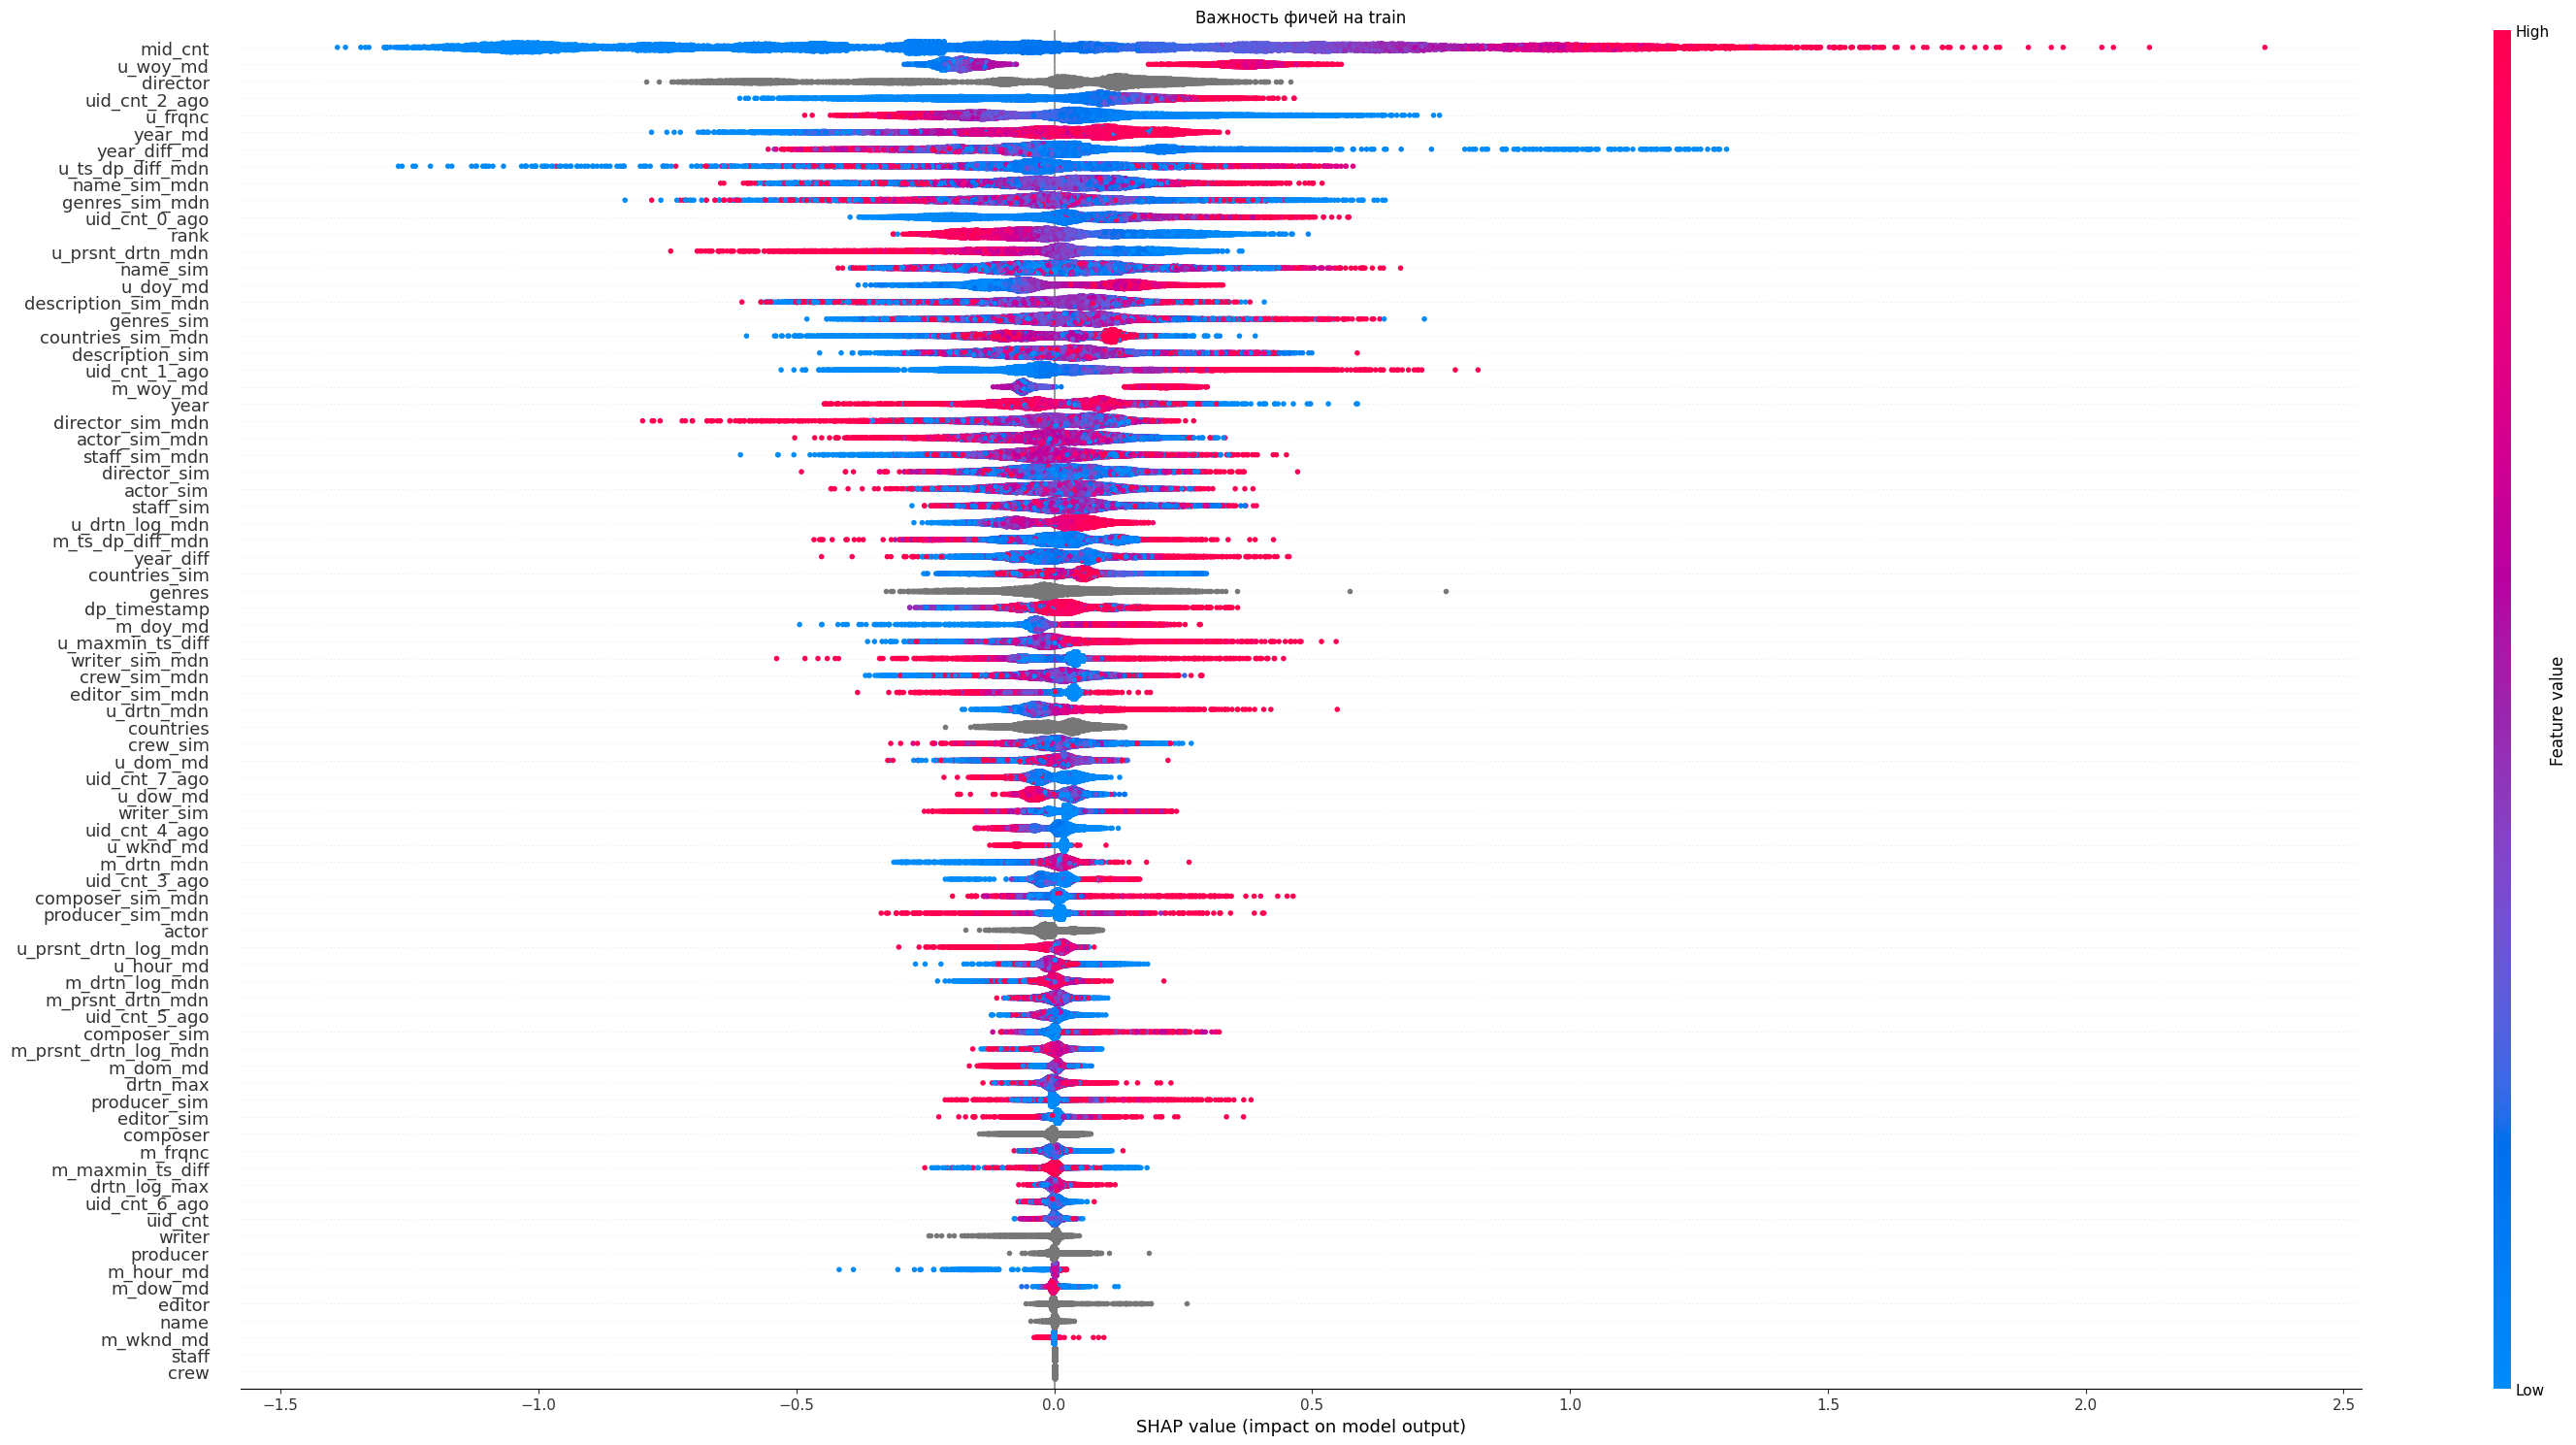

In [ ]:
plt.title("Важность фичей на train")
shap.summary_plot(shap_values, X_train_subs, max_display=80, plot_size=(30, 15))

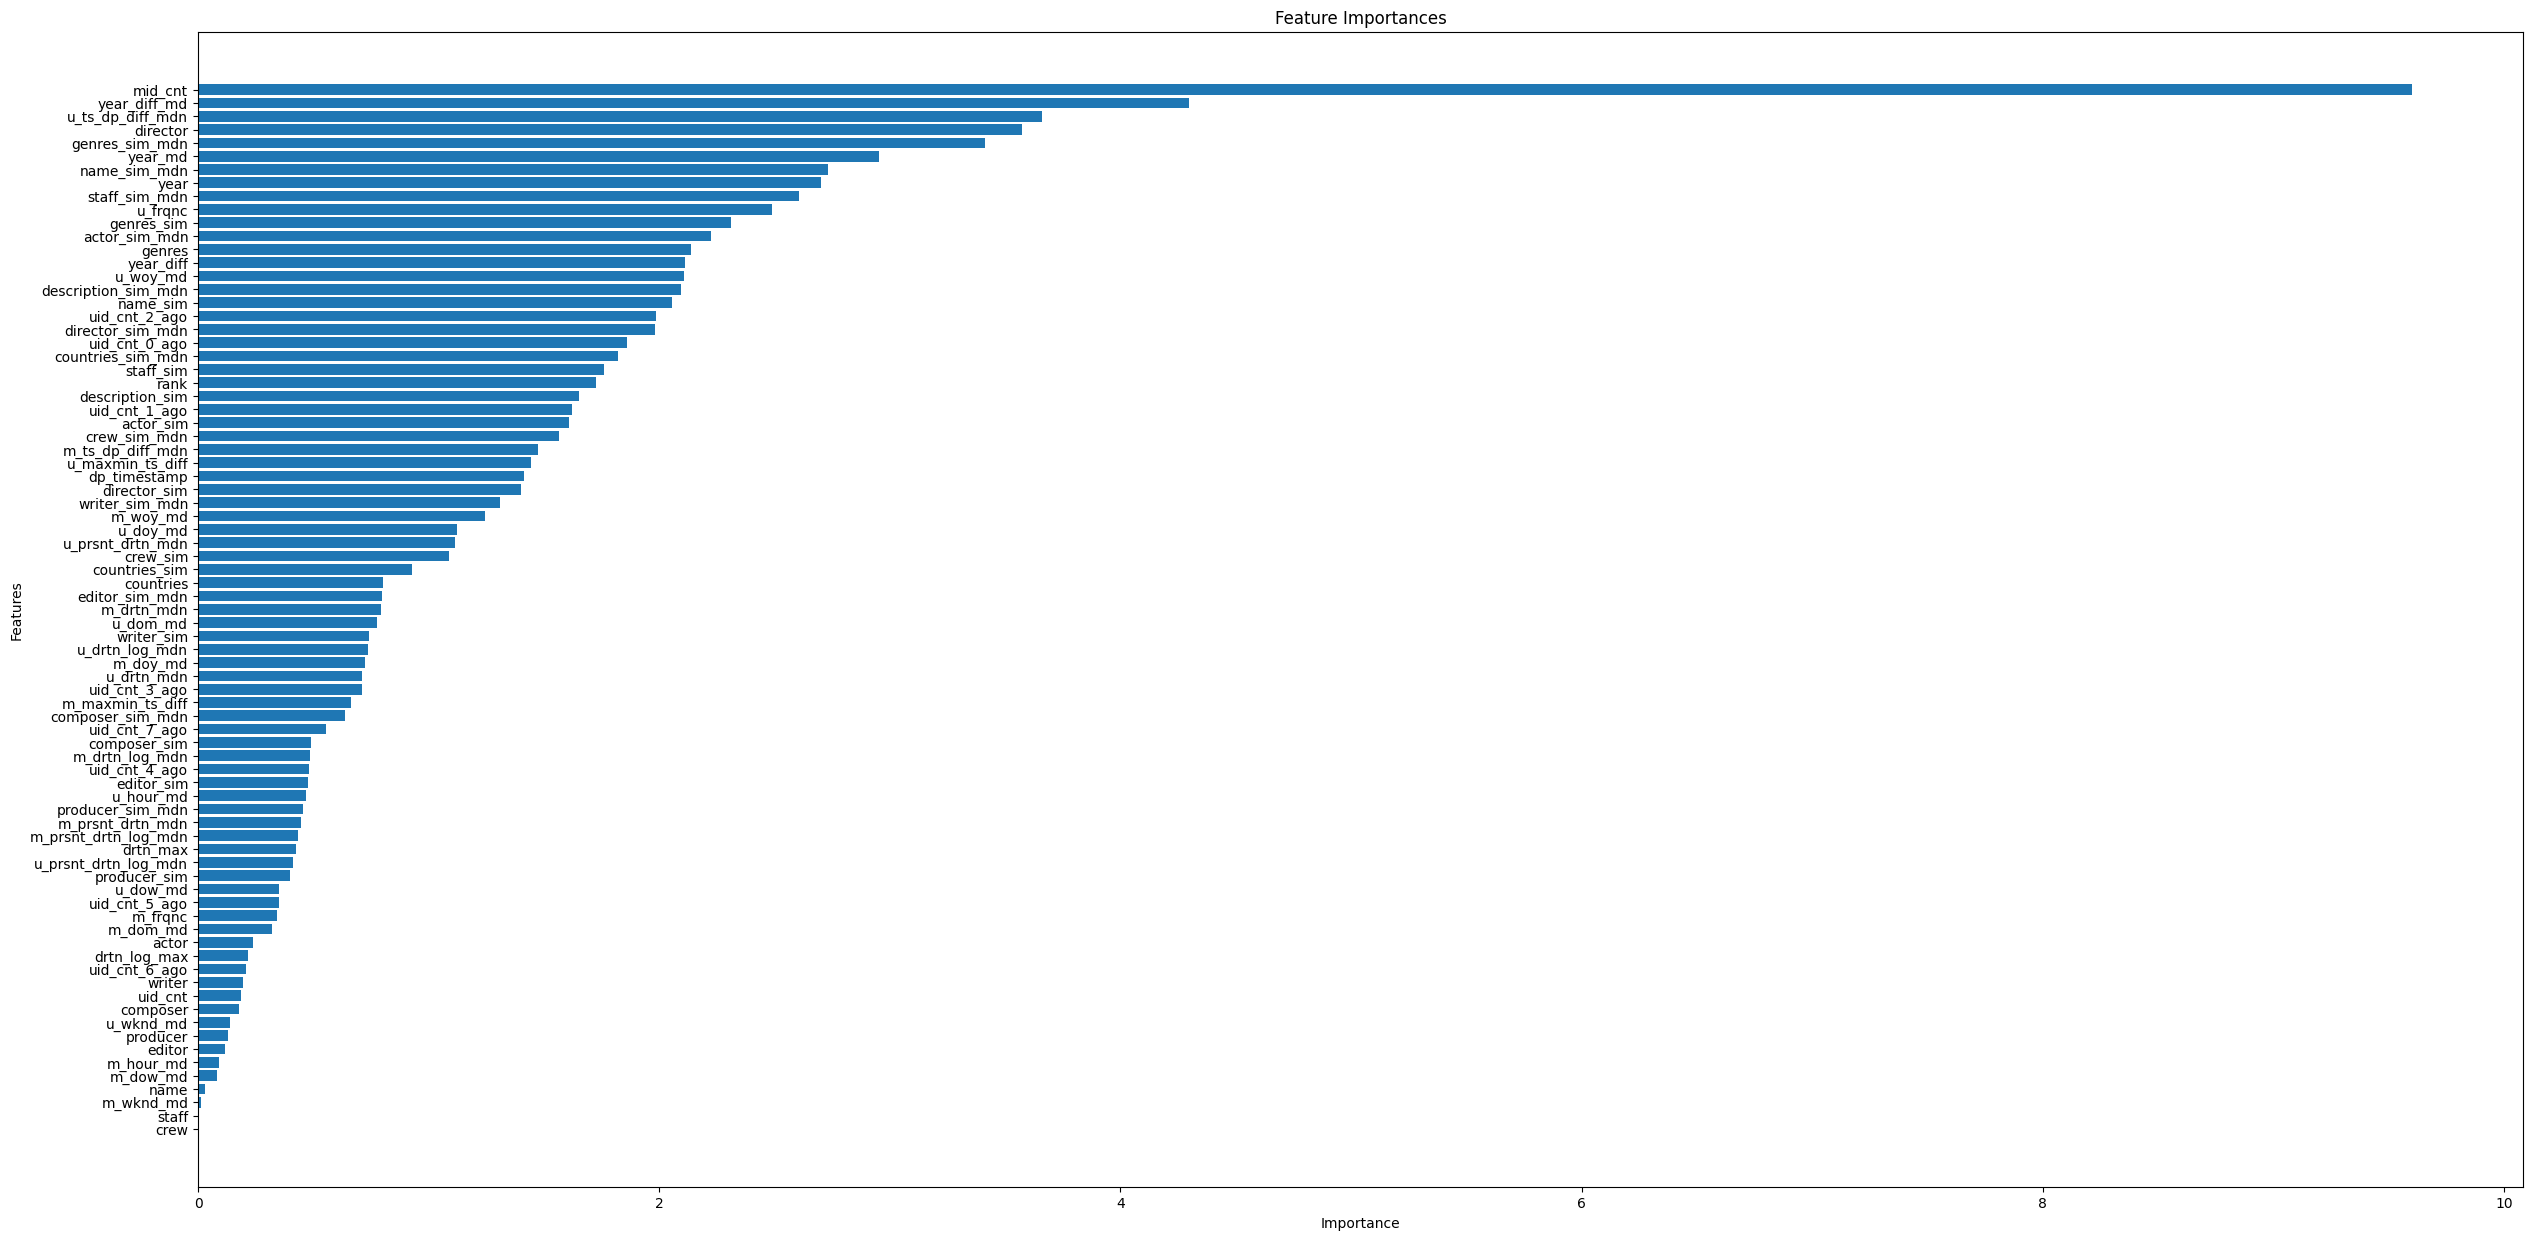

In [ ]:
feature_names = X_train.columns.to_list()
#
feature_importances = ctb_model.feature_importances_

# Сортировка значимости по убыванию
sorted_indices = feature_importances.argsort()[::1]
sorted_importances = feature_importances[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(30, 15))
# Create a horizontal bar plot of the feature importances
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()



---



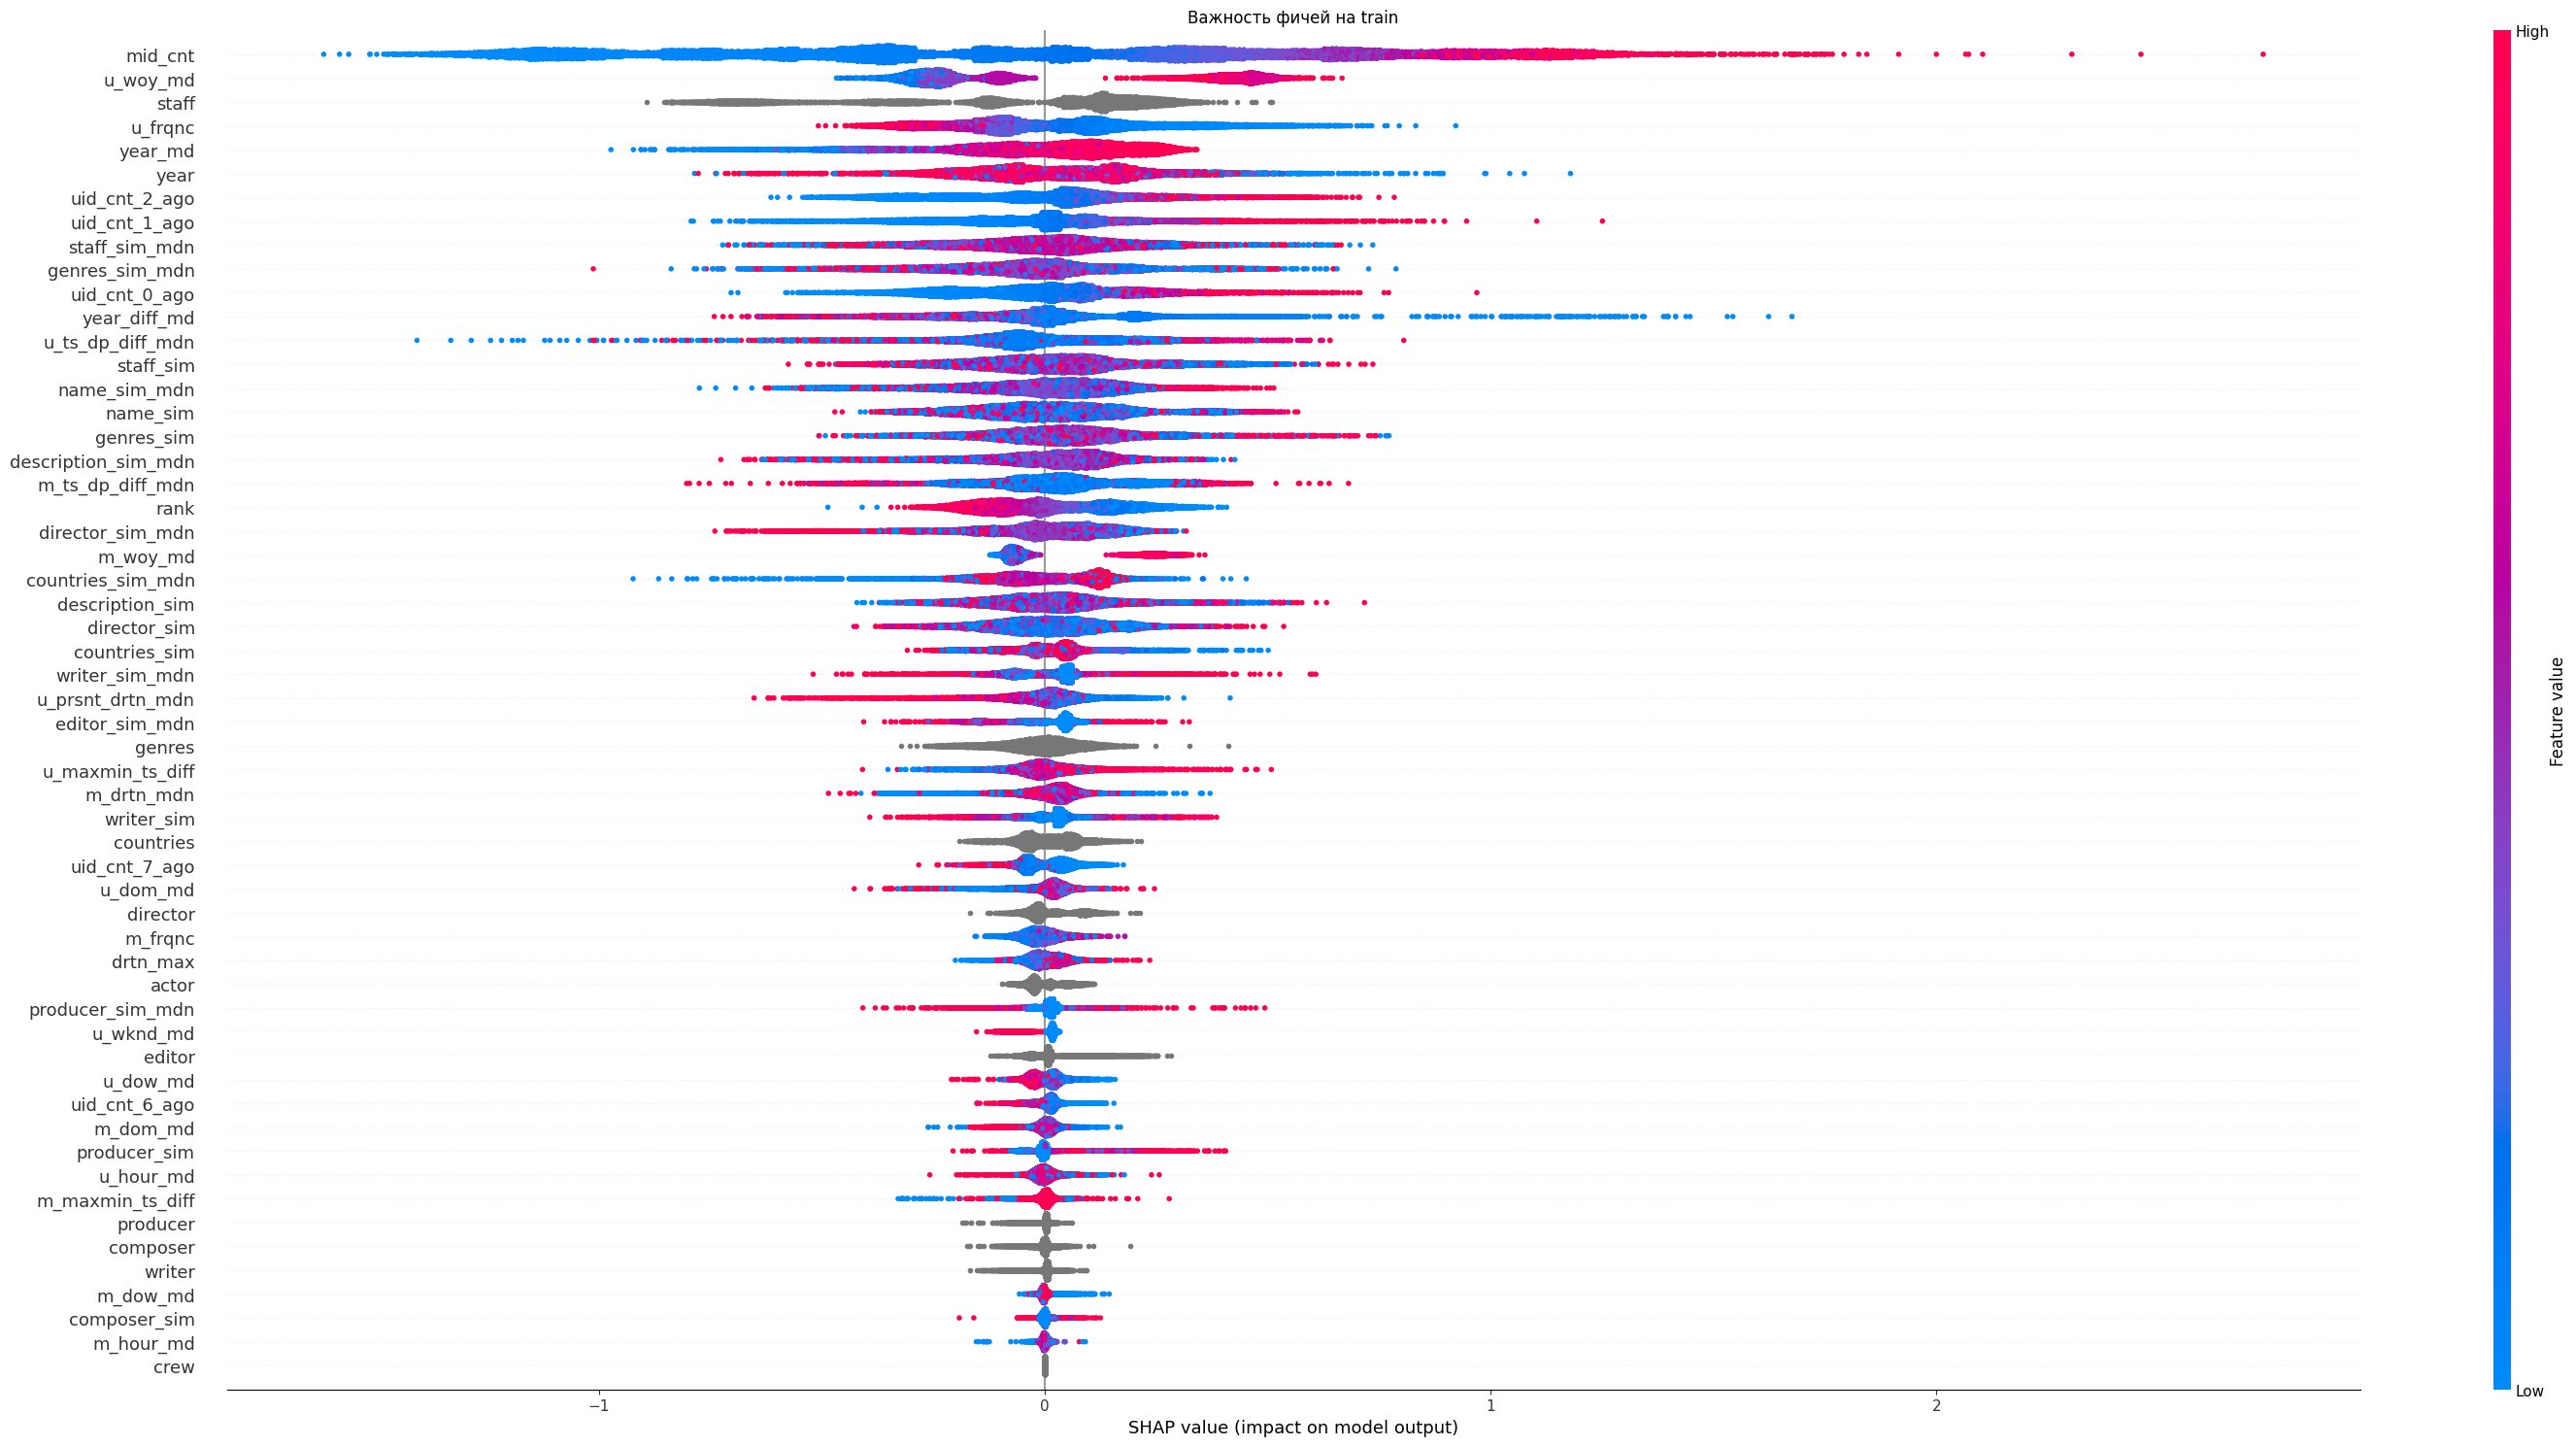

In [ ]:
plt.title("Важность фичей на train")
shap.summary_plot(shap_values, X_train_subs, max_display=80, plot_size=(30, 15))

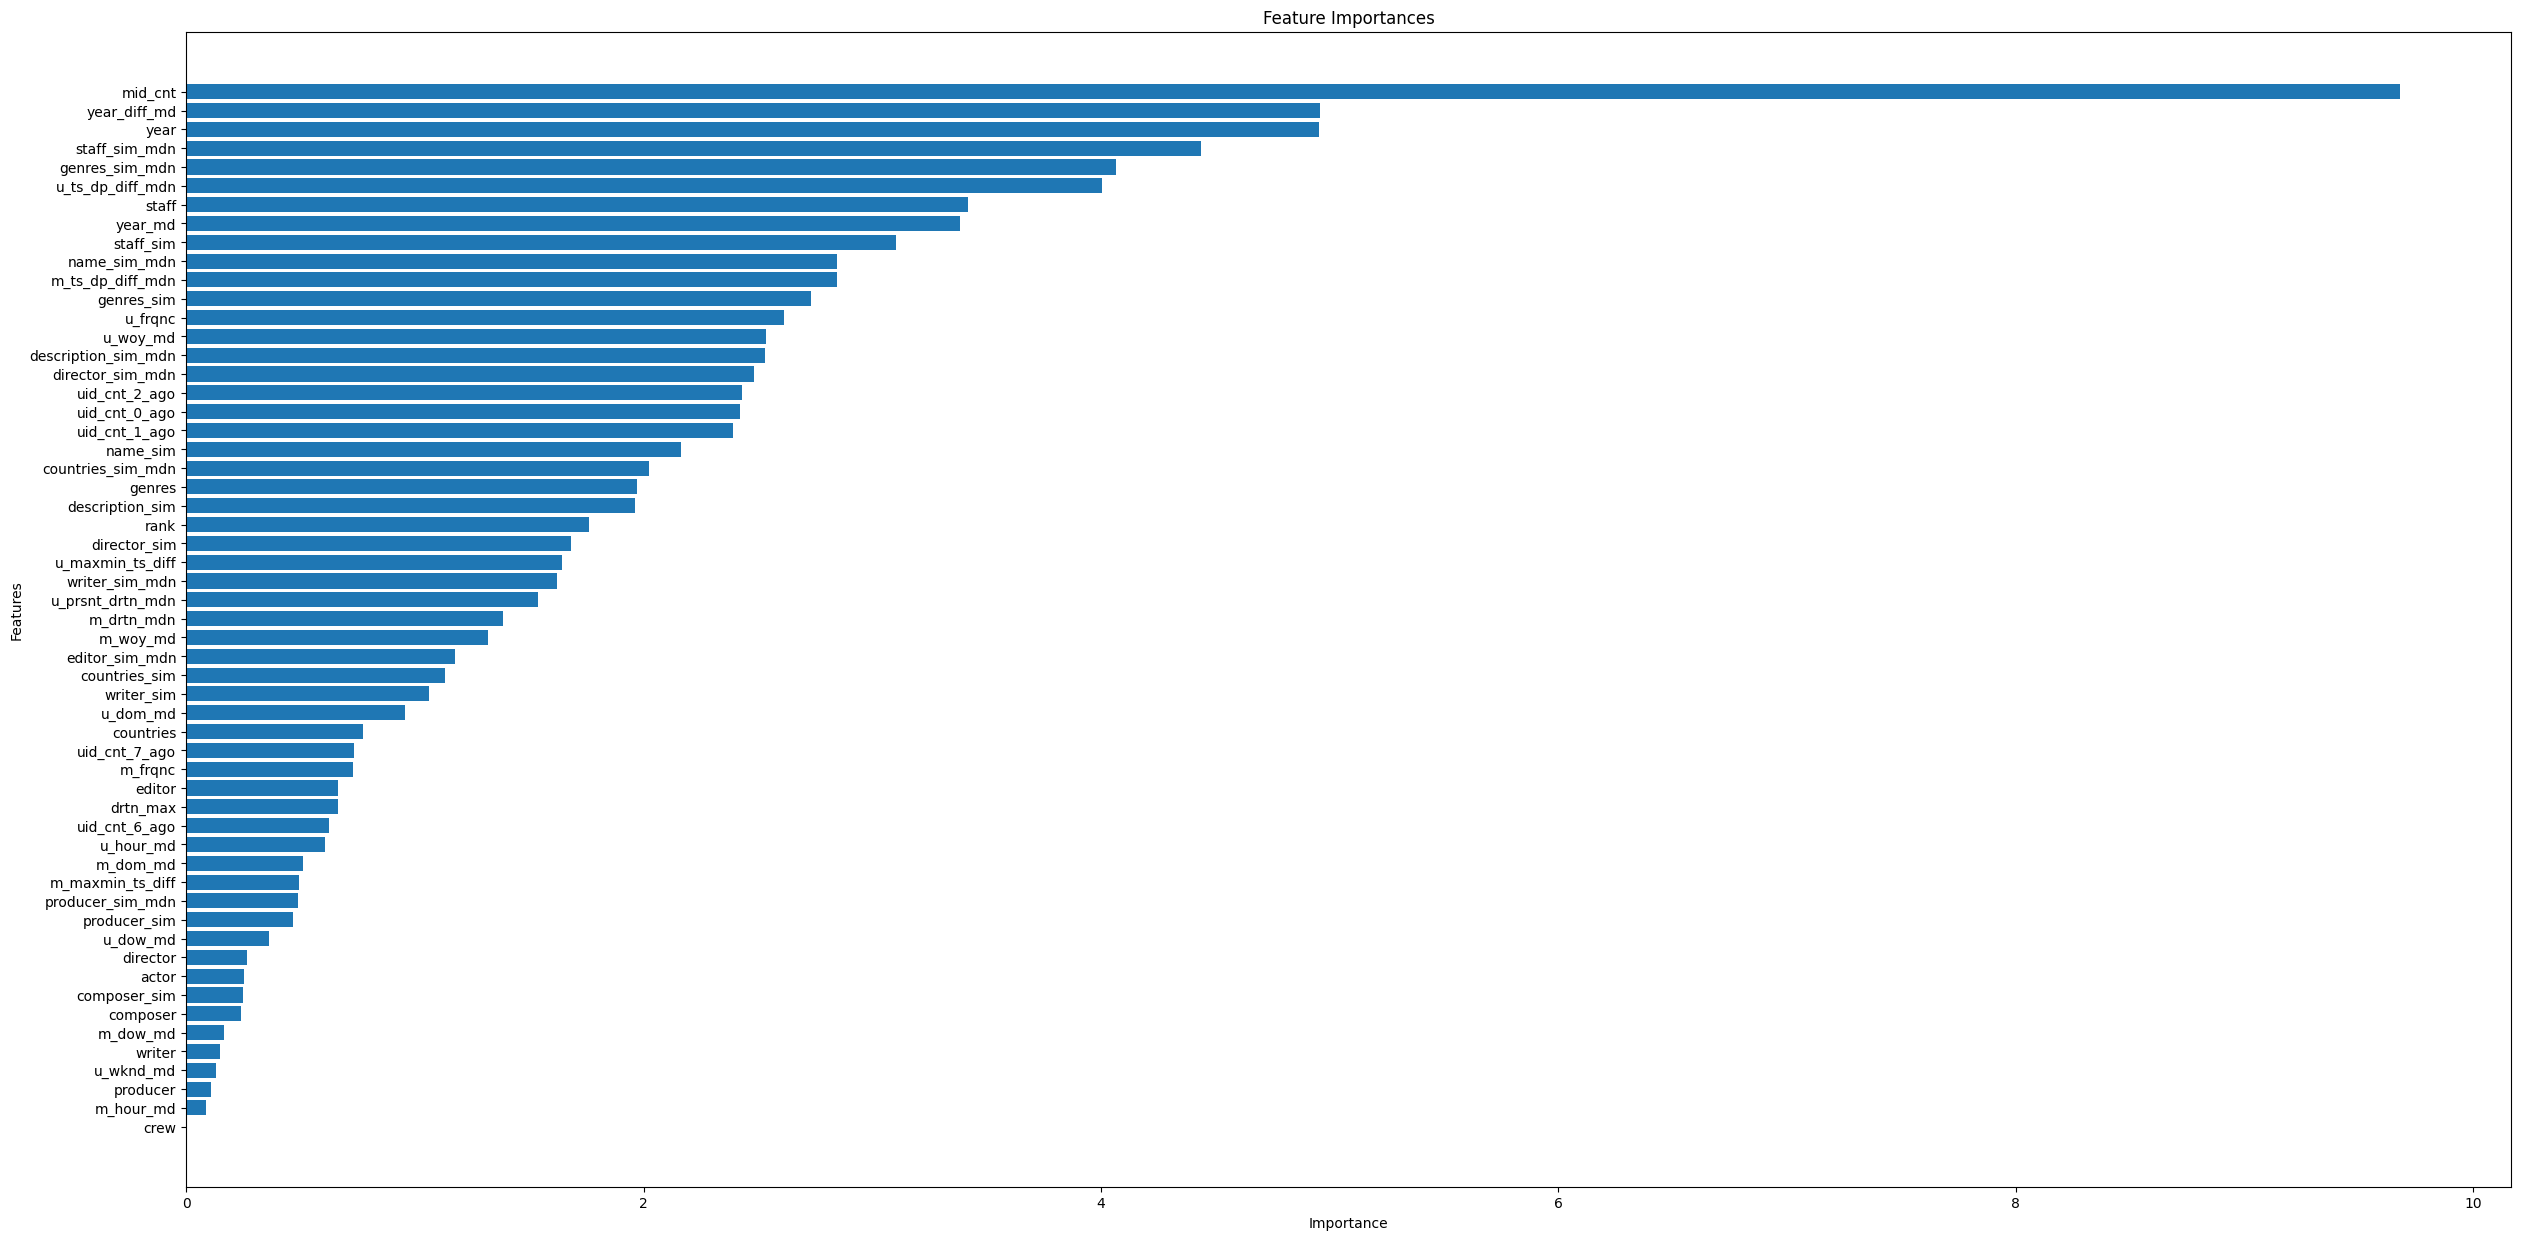

In [ ]:
feature_names = X_train.columns.to_list()
#
feature_importances = ctb_model.feature_importances_

# Сортировка значимости по убыванию
sorted_indices = feature_importances.argsort()[::1]
sorted_importances = feature_importances[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(30, 15))
# Create a horizontal bar plot of the feature importances
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

Оценим метрики catboost модели

In [ ]:
test_feat = ctb_test.merge(train_users[user_col], on=['user_id'], how='left') \
                    .merge(train_movies[item_col], on=['movie_id'], how='left')

In [ ]:
# test_feat = ctb_test.merge(movies[item_col], on=['movie_id'], how='left')
# test_feat.head()

In [ ]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']
# X_test.head()

In [ ]:
y_pred = ctb_model.predict_proba(X_test)


In [ ]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.87'

### Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost
- Сравниваем

### 1) Метрики качества LightFM

In [ ]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]


In [ ]:
%%time
top_N = 100

lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)
# lfm_prediction.head()

CPU times: user 2min 39s, sys: 12 s, total: 2min 51s
Wall time: 2min 7s


In [ ]:
lfm_prediction = lfm_prediction.explode('movie_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1

1 этап LightFM: Метрики Precision@k, Recall@k, MAP@k, MRR

k = 1, .., 20

In [ ]:
lfm_metrics = compute_metrics(test[['user_id', 'movie_id']],
                              lfm_prediction,
                              top_N=20)
lfm_metrics

Precision@5     0.026308
Recall@5        0.031470
Precision@10    0.024487
Recall@10       0.054697
Precision@15    0.022446
Recall@15       0.072013
Precision@20    0.020862
Recall@20       0.086533
MAP@20          0.031647
MRR             0.085207
dtype: float64

In [ ]:
lfm_metrics = compute_metrics(test[['user_id', 'movie_id']],
                              lfm_prediction,
                              top_N=20)
lfm_metrics

Precision@5     0.026308
Recall@5        0.031470
Precision@10    0.024487
Recall@10       0.054697
Precision@15    0.022446
Recall@15       0.072013
Precision@20    0.020862
Recall@20       0.086533
MAP@20          0.031647
MRR             0.085207
dtype: float64

In [ ]:
gc.collect()

0

### 2) Метрики качества двухэтапной модели: LightFM + Catboost

In [ ]:
lfm_ctb_prediction = lfm_prediction.copy()

score_feat = lfm_ctb_prediction.merge(train_users[user_col], on=['user_id'], how='left') \
                               .merge(train_movies[item_col], on=['movie_id'], how='left')


In [ ]:
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
# lfm_ctb_prediction.head()

In [ ]:
gc.collect()

0

Проставляем итоговый ранк двухэтапной модели

In [ ]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1
# lfm_ctb_prediction.head()

In [ ]:
# интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 20]['rank'],
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 20]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

In [ ]:
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 20]['rank'],
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 20]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

In [ ]:
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 20]['rank'],
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 20]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

1+2 этапы LightFM + Сatboost: Метрики

k = 1, .., 20

In [ ]:
model_2step_metrics = compute_metrics(test[['user_id', 'movie_id']],
                                      lfm_ctb_prediction,
                                      top_N=20,
                                      rank_col='rank_ctb')
model_2step_metrics

Precision@5     0.024920
Recall@5        0.027548
Precision@10    0.024576
Recall@10       0.052235
Precision@15    0.023541
Recall@15       0.073444
Precision@20    0.022491
Recall@20       0.091476
MAP@20          0.027563
MRR             0.075327
dtype: float64

In [ ]:
model_2step_metrics = compute_metrics(test[['user_id', 'movie_id']],
                                      lfm_ctb_prediction,
                                      top_N=20,
                                      rank_col='rank_ctb')
model_2step_metrics

Precision@5     0.025059
Recall@5        0.027107
Precision@10    0.024441
Recall@10       0.052150
Precision@15    0.023268
Recall@15       0.073065
Precision@20    0.022270
Recall@20       0.090887
MAP@20          0.027203
MRR             0.075490
dtype: float64

In [ ]:
# overfited
model_2step_metrics = compute_metrics(test[['user_id', 'movie_id']],
                                      lfm_ctb_prediction,
                                      top_N=20,
                                      rank_col='rank_ctb')
model_2step_metrics

Precision@5     0.051921
Recall@5        0.073371
Precision@10    0.041924
Recall@10       0.105446
Precision@15    0.036117
Recall@15       0.128177
Precision@20    0.032245
Recall@20       0.145906
MAP@20          0.063374
MRR             0.147971
dtype: float64

🧐 Сравнение метрик

In [ ]:
df_metrics = pd.concat([pd.DataFrame(lfm_metrics).transpose(),
                        pd.DataFrame(model_2step_metrics).transpose()])

df_metrics.index = ['lightfm', 'model_2step']
df_metrics

Precision@5  Recall@5  Precision@10  Recall@10  Precision@15  \
lightfm         0.026308  0.031470      0.024487   0.054697      0.022446   
model_2step     0.024920  0.027548      0.024576   0.052235      0.023541   

             Recall@15  Precision@20  Recall@20    MAP@20       MRR  
lightfm       0.072013      0.020862   0.086533  0.031647  0.085207  
model_2step   0.073444      0.022491   0.091476  0.027563  0.075327

In [ ]:
df_metrics = pd.concat([pd.DataFrame(lfm_metrics).transpose(),
                        pd.DataFrame(model_2step_metrics).transpose()])

df_metrics.index = ['lightfm', 'model_2step']
df_metrics

Precision@5  Recall@5  Precision@10  Recall@10  Precision@15  \
lightfm         0.026308  0.031470      0.024487   0.054697      0.022446   
model_2step     0.025059  0.027107      0.024441   0.052150      0.023268   

             Recall@15  Precision@20  Recall@20    MAP@20       MRR  
lightfm       0.072013      0.020862   0.086533  0.031647  0.085207  
model_2step   0.073065      0.022270   0.090887  0.027203  0.075490

In [ ]:
df_metrics = pd.concat([pd.DataFrame(lfm_metrics).transpose(),
                        pd.DataFrame(model_2step_metrics).transpose()])

df_metrics.index = ['lightfm', 'model_2step']
df_metrics

Precision@5  Recall@5  Precision@10  Recall@10  Precision@15  \
lightfm         0.026204  0.030740      0.024027   0.053380      0.022656   
model_2step     0.051921  0.073371      0.041924   0.105446      0.036117   

             Recall@15  Precision@20  Recall@20    MAP@20       MRR  
lightfm       0.072683      0.021391   0.088987  0.031262  0.082997  
model_2step   0.128177      0.032245   0.145906  0.063374  0.147971

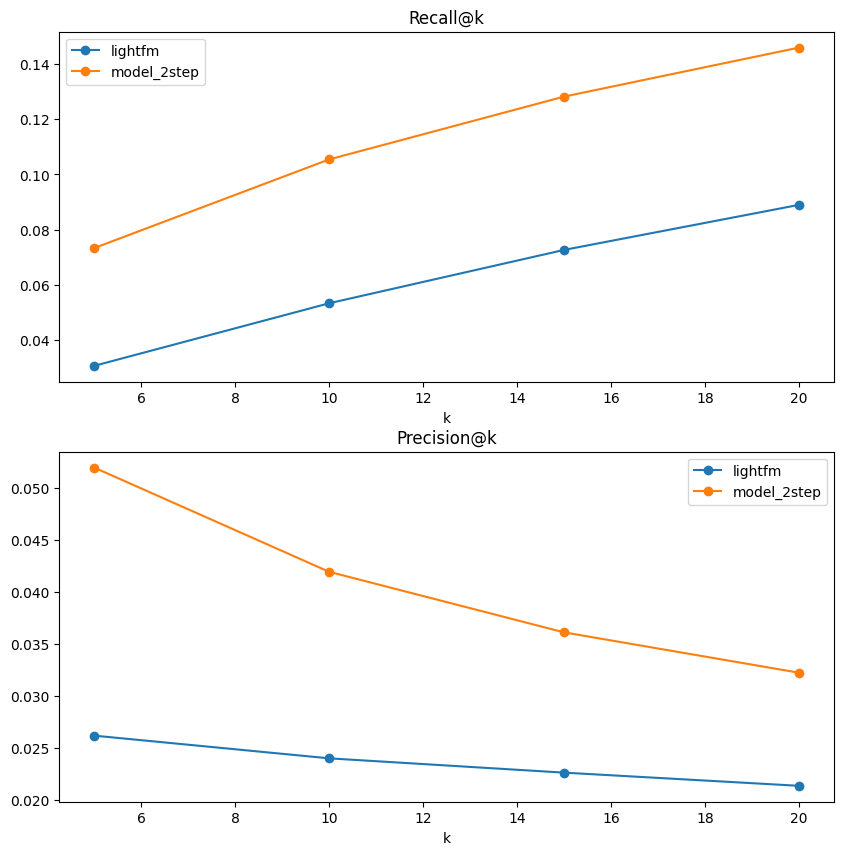

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(5, 21, 5),
                        df_metrics.loc[model][[metric+f'{k}' for k in range(5, 21, 5)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')

## Прогноз на всех данных

In [ ]:
logs = pd.read_csv('/content/train/logs.csv', parse_dates=['datetime'])
logs['movie_id'] = logs['movie_id'].astype(int)

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/result_g4r_vd.csv')

In [ ]:
predict = pd.DataFrame({'user_id': logs['user_id'].unique()})
predict = predict.merge(result, on='user_id', how='left')

In [ ]:
result

user_id                                           movie_id
0        10250  ['2775', '805', '1401', '4991', '6915', '466',...
1         2062  ['4048', '4827', '3492', '5530', '2755', '4480...
2        30646  ['484', '5473', '2677', '1907', '1806', '6944'...
3        43069  ['484', '5336', '5144', '3715', '6257', '897',...
4        46037  ['3070', '2673', '5516', '4845', '1267', '6822...
...        ...                                                ...
98327   203856  ['801', '254', '6861', '3476', '3238', '2255',...
98328   229469  ['6165', '244', '3876', '2688', '5849', '2526'...
98329   187947  ['215', '5474', '2820', '1543', '876', '5056',...
98330   166730  ['6600', '3003', '6444', '6048', '6241', '753'...
98331   207852  ['1282', '988', '4109', '6814', '1720', '1014'...

[98332 rows x 2 columns]

In [ ]:
result['movie_id'] = result['movie_id'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Получите список топ 20 фильмов из датафрейма logs
top_20 = logs['movie_id'].value_counts().head(20).index.to_list()

# Определите функцию, которая проверяет, является ли значение не списком,
# и возвращает список топ 20 фильмов или исходное значение
def fill_with_top_20(value):
    if not isinstance(value, list): # Проверьте, является ли значение списком
        return top_20 # Верните список топ 20 фильмов
    else: # Если значение не является списком, то верните его без изменений
        return value

# Примените функцию к колонке movie_id датафрейма predict
predict['movie_id'] = predict['movie_id'].apply(fill_with_top_20)

In [ ]:
predict

user_id                                           movie_id
0         10250  [2775, 805, 1401, 4991, 6915, 466, 7173, 1769,...
1          2062  [4048, 4827, 3492, 5530, 2755, 4480, 7057, 334...
2         12980  [7369, 6042, 6217, 4299, 3261, 1714, 1924, 164...
3         30646  [484, 5473, 2677, 1907, 1806, 6944, 7020, 4742...
4         43069  [484, 5336, 5144, 3715, 6257, 897, 5491, 4958,...
...         ...                                                ...
207372   224150  [484, 6194, 2820, 641, 7173, 5849, 1281, 1978,...
207373   227931  [484, 6194, 2820, 641, 7173, 5849, 1281, 1978,...
207374   143732  [484, 6194, 2820, 641, 7173, 5849, 1281, 1978,...
207375    58404  [484, 6194, 2820, 641, 7173, 5849, 1281, 1978,...
207376    58226  [484, 6194, 2820, 641, 7173, 5849, 1281, 1978,...

[207377 rows x 2 columns]

In [ ]:
predict = predict.explode('movie_id')
predict['user_id'] = predict['user_id'].astype(int)
predict['movie_id'] = predict['movie_id'].astype(int)
predict = predict.groupby('user_id')['movie_id'].agg(list).reset_index()

In [ ]:
logs_movies = logs.merge(movies, on='movie_id', how='left')

logs_movies['ts_dp_diff'] = logs_movies['timestamp'] - logs_movies['dp_timestamp']
logs_movies['prsnt_drtn'] = logs_movies['duration'] / logs_movies['drtn_max']
logs_movies['prsnt_drtn_log'] = logs_movies['drtn_log'] / logs_movies['drtn_log_max']



---



In [ ]:
logs_movies.columns

Index(['id', 'datetime', 'user_id', 'movie_id', 'duration', 'timestamp',
       'dayofyear', 'weekofyear', 'month', 'day', 'dayofweek', 'is_weekend',
       'hour', 'drtn_log', 'name', 'year', 'description', 'genres',
       'countries', 'staff', 'actor', 'producer', 'editor', 'director',
       'writer', 'composer', 'year_diff', 'drtn_max', 'drtn_log_max',
       'dp_timestamp', 'crew', 'dscrptn_sim', 'title_sim', 'genres_sim',
       'countries_sim', 'staff_sim', 'actor_sim', 'crew_sim', 'uid_cnt_w14',
       'uid_cnt_w15', 'uid_cnt_w16', 'uid_cnt_w17', 'uid_cnt_w18',
       'uid_cnt_w19', 'uid_cnt_w20', 'uid_cnt_w21', 'uid_cnt_w22',
       'uid_cnt_w23', 'uid_cnt_w24', 'ts_dp_diff', 'prsnt_drtn',
       'prsnt_drtn_log'],
      dtype='object')

In [ ]:
%%time
# Группировка по user_id и вычисление необходимых статистик
users = logs_movies.groupby('user_id').agg({
    'movie_id': 'count',
    'duration': 'median',
    'drtn_log': 'median',
    'timestamp': lambda x: x.max() - x.min(),
    'year': lambda x: x.mode().values[0],
    'year_diff': lambda x: x.mode().values[0],
    'dscrptn_sim': 'median',
    'title_sim': 'median',
    'genres_sim': 'median',
    'countries_sim': 'median',
    'staff_sim': 'median',
    'actor_sim': 'median',
    'crew_sim': 'median',
    'ts_dp_diff': 'median',
    'prsnt_drtn': 'median',
    'prsnt_drtn_log': 'median',
    'dayofweek': lambda x: x.mode().values[0],
    'hour': lambda x: x.mode().values[0],
}).reset_index().rename(columns={
    'movie_id': 'iid_cnt',
    'duration': 'u_drtn_mdn',
    'drtn_log': 'u_drtn_log_mdn',
    'timestamp': 'u_maxmin_ts_diff',
    'year': 'year_md',
    'year_diff': 'year_diff_md',
    'dscrptn_sim': 'dscrptn_sim_mdn',
    'title_sim': 'ttls_sim_mdn',
    'genres_sim': 'gnrs_sim_mdn',
    'countries_sim': 'cntrs_sim_mdn',
    'staff_sim': 'stff_sim_mdn',
    'actor_sim': 'actrs_sim_mdn',
    'crew_sim': 'crew_sim_mdn',
    'ts_dp_diff': 'u_ts_dp_diff_mdn',
    'prsnt_drtn': 'u_prsnt_drtn_mdn',
    'prsnt_drtn_log': 'u_prsnt_drtn_log_mdn',
    'dayofweek': 'u_dow_md',
    'hour': 'u_hour_md',
})
users['u_drtn_mdn'] = users['u_drtn_mdn'].astype(int)
users['u_frqnc'] = users['u_maxmin_ts_diff'] / users['iid_cnt']
users['u_frqnc'] = users['u_frqnc'].astype(int)
users['u_ts_dp_diff_mdn'] = users['u_ts_dp_diff_mdn'].astype(int)

CPU times: user 2min 47s, sys: 2.19 s, total: 2min 49s
Wall time: 2min 50s


In [ ]:
%%time
# Группировка по user_id и вычисление необходимых статистик
grouped = logs_movies.groupby('movie_id').agg({
    'duration': 'median',
    'drtn_log': 'median',
    'timestamp': lambda x: x.max() - x.min(),
    'ts_dp_diff': 'median',
    'prsnt_drtn': 'median',
    'prsnt_drtn_log': 'median',
    'dayofweek': lambda x: x.mode().values[0],
    'hour': lambda x: x.mode().values[0],
}).reset_index().rename(columns={
    'duration': 'm_drtn_mdn',
    'drtn_log': 'm_drtn_log_mdn',
    'timestamp': 'm_maxmin_ts_diff',
    'ts_dp_diff': 'm_ts_dp_diff_mdn',
    'prsnt_drtn': 'm_prsnt_drtn_mdn',
    'prsnt_drtn_log': 'm_prsnt_drtn_log_mdn',
    'dayofweek': 'm_dow_md',
    'hour': 'm_hour_md',
})
grouped['m_drtn_mdn'] = grouped['m_drtn_mdn'].astype(int)
grouped['m_frqnc'] = grouped['m_maxmin_ts_diff'] / grouped['iid_cnt']
grouped['m_frqnc'] = grouped['m_frqnc'].astype(int)
grouped['m_ts_dp_diff_mdn'] = grouped['m_ts_dp_diff_mdn'].astype(int)

movies = movies.merge(grouped, on='movie_id', how='left')



---

# GRU4Rec

In [ ]:
!pip install recbole ray kmeans-pytorch

In [ ]:
import torch

# Для вывода работы библиотеки RecBole
import logging
from logging import getLogger
# Для типизации функций
from typing import List, Tuple
from collections import defaultdict

from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import GRU4Rec, Caser
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger#!
from recbole.utils.case_study import full_sort_topk

# Для того чтобы тетрадка запускалась и на CPU, и на GPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
recbole_data_inter = logs[['user_id', 'movie_id', 'timestamp']]
recbole_data_inter.columns = ['user_id:token', 'item_id:token', 'timestamp:float']

In [ ]:
recbole_folder = '/content/drive/MyDrive/colab_notebooks/gs_labs/recbole_data'
if not os.path.exists(recbole_folder):
    os.makedirs(recbole_folder)

recbole_data_inter_folder = ('/content/drive/MyDrive/colab_notebooks/gs_labs/recbole_data/' + 'recbole_data.inter')
# if not os.path.exists(recbole_data_inter_folder):
recbole_data_inter.to_csv(recbole_data_inter_folder, sep='\t', index=False)

In [ ]:
config_dict = {
    "USER_ID_FIELD": "user_id",
    "ITEM_ID_FIELD": "item_id",
    "TIME_FIELD": "timestamp",
    "load_col": {"inter": ["user_id", "item_id", "timestamp"]},
    "ITEM_LIST_LENGTH_FIELD": "item_length",
    "LIST_SUFFIX": "_list",
    "MAX_ITEM_LIST_LENGTH": 130,
    "embedding_size": 256,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout_prob": 0.3,
    "loss_type": "CE",
    "epochs": 50,
    "train_batch_size": 4096,
    "eval_batch_size": 4096,
    "train_neg_sample_args": None,
    "eval_args": {
        "group_by": "user",
        "order": "TO",
        "split": {"LS": "valid_only"},
        "mode": "full",
    },
    "metrics": ["MAP"],
    "topk": 20,
    "valid_metric": "MAP@20",
    "data_path": "/content/drive/MyDrive/colab_notebooks/gs_labs/",
    "stopping_step": 3,
    "device": DEVICE,
}

In [ ]:
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
config = Config(model='GRU4Rec', dataset='recbole_data', config_dict=config_dict)

init_seed(config['seed'], config['reproducibility'])

# инициализируем логгеры для вывода информации
logger = getLogger()
logger.setLevel(logging.INFO)

c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)

logger.addHandler(c_handler)
logger.info(config)

# Создаём объекты тренировочной выборки и валидацонной:
dataset = create_dataset(config)
logger.info(dataset)
train_data, valid_data, test_data = data_preparation(config, dataset)

# Инициализируем модель и обучаем.
model = GRU4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

# инициализируем "тренера" модели
trainer = Trainer(config, model)

# сохраняем лучшие результаты
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)

INFO:root:
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /content/drive/MyDrive/colab_notebooks/gs_labs/recbole_data
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 50
train_batch_size = 4096
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 3
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'LS': 'valid_only'}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['MAP']
topk = [20]
valid_metric = MAP@20
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Parameters:
field_se

In [ ]:
# valid_data
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id],
                                      model,
                                      valid_data,
                                      k=20,
                                      device=config['device'])
    if topk_iid_list.shape[0] > 0:  # Check if any items are recommended
        last_topk_iid_list = topk_iid_list[-1]
        external_item_list = dataset.id2token(
            dataset.iid_field, last_topk_iid_list.cpu()
            ).tolist()
        topk_items.append(external_item_list)
print(len(topk_items))

# fist element in array is 'PAD' (default of Recbole) -> remove it
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num))
    )[1:]

external_item_str = [' '.join(x) for x in topk_items]
# Assuming external_user_ids and external_item_str are defined as in your code
result = pd.DataFrame(external_user_ids, columns=['user_id'])
# Check if lengths are different
if len(external_item_str) != len(result):
    # Extend external_item_str with NaNs to match the length of result
    external_item_str.extend([np.nan] * (len(result) - len(external_item_str)))

result['movie_id'] = external_item_str
result.info()

98332
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206647 entries, 0 to 206646
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   206647 non-null  object
 1   movie_id  98332 non-null   object
dtypes: object(2)
memory usage: 3.2+ MB


In [ ]:
result

user_id                                           movie_id
0        10250  2775 805 1401 4991 6915 466 7173 1769 3020 197...
1         2062  4048 4827 3492 5530 2755 4480 7057 3347 2974 1...
2        30646  484 5473 2677 1907 1806 6944 7020 4742 6194 37...
3        43069  484 5336 5144 3715 6257 897 5491 4958 6674 390...
4        46037  3070 2673 5516 4845 1267 6822 1252 2025 6830 1...
...        ...                                                ...
206642  227931                                                NaN
206643   50316                                                NaN
206644  143732                                                NaN
206645   58404                                                NaN
206646   58226                                                NaN

[206647 rows x 2 columns]

In [ ]:
result.dropna(inplace=True)

In [ ]:
# Преобразуем 'movie_id' в список
result['movie_id'] = result['movie_id'].str.split(' ').map(list)

In [ ]:
result

user_id                                           movie_id
0       10250  [2775, 805, 1401, 4991, 6915, 466, 7173, 1769,...
1        2062  [4048, 4827, 3492, 5530, 2755, 4480, 7057, 334...
2       30646  [484, 5473, 2677, 1907, 1806, 6944, 7020, 4742...
3       43069  [484, 5336, 5144, 3715, 6257, 897, 5491, 4958,...
4       46037  [3070, 2673, 5516, 4845, 1267, 6822, 1252, 202...
...       ...                                                ...
98327  203856  [801, 254, 6861, 3476, 3238, 2255, 476, 1875, ...
98328  229469  [6165, 244, 3876, 2688, 5849, 2526, 3315, 285,...
98329  187947  [215, 5474, 2820, 1543, 876, 5056, 4176, 5571,...
98330  166730  [6600, 3003, 6444, 6048, 6241, 753, 3929, 1510...
98331  207852  [1282, 988, 4109, 6814, 1720, 1014, 209, 5512,...

[98332 rows x 2 columns]

In [ ]:
result.to_csv('result_g4r_vd.csv', index=False)

In [ ]:
result_g4r_vd = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/result_g4r_vd.csv')

In [ ]:
result_g4r_vd['movie_id'] = result_g4r_vd['movie_id'].apply(lambda x: ast.literal_eval(x))

In [ ]:
result_g4r_vd

user_id                                           movie_id
0        10250  [2775, 805, 1401, 4991, 6915, 466, 7173, 1769,...
1         2062  [4048, 4827, 3492, 5530, 2755, 4480, 7057, 334...
2        30646  [484, 5473, 2677, 1907, 1806, 6944, 7020, 4742...
3        43069  [484, 5336, 5144, 3715, 6257, 897, 5491, 4958,...
4        46037  [3070, 2673, 5516, 4845, 1267, 6822, 1252, 202...
...        ...                                                ...
98327   203856  [801, 254, 6861, 3476, 3238, 2255, 476, 1875, ...
98328   229469  [6165, 244, 3876, 2688, 5849, 2526, 3315, 285,...
98329   187947  [215, 5474, 2820, 1543, 876, 5056, 4176, 5571,...
98330   166730  [6600, 3003, 6444, 6048, 6241, 753, 3929, 1510...
98331   207852  [1282, 988, 4109, 6814, 1720, 1014, 209, 5512,...

[98332 rows x 2 columns]



---



In [ ]:
topk_items = []
for internal_user_id in list(range(dataset.user_num))[1:]:
    _, topk_iid_list = full_sort_topk([internal_user_id],
                                      model,
                                      train_data,
                                      k=20,
                                      device=config['device'])
    if topk_iid_list.shape[0] > 0:  # Check if any items are recommended
        last_topk_iid_list = topk_iid_list[-1]
        external_item_list = dataset.id2token(
            dataset.iid_field, last_topk_iid_list.cpu()
            ).tolist()
        topk_items.append(external_item_list)
print(len(topk_items))

# fist element in array is 'PAD' (default of Recbole) -> remove it
external_user_ids = dataset.id2token(
    dataset.uid_field, list(range(dataset.user_num))
    )[1:]

external_item_str = [' '.join(x) for x in topk_items]
# Assuming external_user_ids and external_item_str are defined as in your code
result = pd.DataFrame(external_user_ids, columns=['user_id'])
# Check if lengths are different
if len(external_item_str) != len(result):
    # Extend external_item_str with NaNs to match the length of result
    external_item_str.extend([np.nan] * (len(result) - len(external_item_str)))

result['movie_id'] = external_item_str
result.info()

128333
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206647 entries, 0 to 206646
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   206647 non-null  object
 1   movie_id  128333 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [ ]:
result.dropna(inplace=True)

In [ ]:
# Преобразуем 'movie_id' в список
result['movie_id'] = result['movie_id'].str.split(' ').map(list)

In [ ]:
result.to_csv('result_g4r_trd.csv', index=False)

In [ ]:
result_g4r_trd = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/result_g4r_trd.csv')

In [ ]:
result_g4r_trd['movie_id'] = result_g4r_trd['movie_id'].apply(lambda x: ast.literal_eval(x))

In [ ]:
result_g4r_trd

user_id                                           movie_id
0         10250  [1401, 6915, 466, 1769, 3509, 4359, 5937, 3663...
1          2062  [1281, 4048, 5336, 2974, 3227, 1953, 2731, 275...
2         30646  [1801, 6507, 5413, 6657, 2591, 4808, 3388, 162...
3         43069  [484, 6257, 897, 5144, 5336, 3133, 1209, 3992,...
4         46037  [2673, 5516, 3070, 4845, 2025, 1252, 5490, 683...
...         ...                                                ...
128328   148661  [1282, 988, 4581, 209, 5788, 2820, 5754, 1226,...
128329    92551  [1281, 1488, 475, 5849, 6091, 5014, 2752, 285,...
128330   114866  [4889, 3851, 3707, 6955, 2820, 2629, 7016, 128...
128331    89609  [1781, 3970, 4167, 1848, 2188, 7016, 5413, 552...
128332   191672  [484, 6194, 6825, 1433, 2480, 5876, 4090, 3637...

[128333 rows x 2 columns]



---



In [ ]:
candidates[['user_id', 'movie_id']].update(result_g4r_vd[['user_id', 'movie_id']])

In [ ]:
df1 = pd.DataFrame([["Emil", "Tobias", "Linus"], [16, 14, 10]]).T
df2 = pd.DataFrame([["Linus"], [17]]).T
df1 = df1.set_index(0)
df2 = df2.set_index(0)

In [ ]:
df1.update(df2)
df1.reset_index()

0   1
0    Emil  16
1  Tobias  14
2   Linus  17

In [ ]:
gc.collect()

5759



---

# LightFM

In [80]:
train_users.columns

Index(['user_id', 'mid_cnt', 'u_drtn_mdn', 'u_drtn_log_mdn',
       'u_maxmin_ts_diff', 'year_md', 'year_diff_md', 'description_sim_mdn',
       'name_sim_mdn', 'genres_sim_mdn', 'countries_sim_mdn', 'staff_sim_mdn',
       'actor_sim_mdn', 'producer_sim_mdn', 'editor_sim_mdn',
       'director_sim_mdn', 'writer_sim_mdn', 'composer_sim_mdn',
       'crew_sim_mdn', 'u_ts_dp_diff_mdn', 'u_prsnt_drtn_mdn',
       'u_prsnt_drtn_log_mdn', 'u_woy_md', 'u_doy_md', 'u_dom_md', 'u_dow_md',
       'u_hour_md', 'u_wknd_md', 'u_frqnc'],
      dtype='object')

In [100]:
train_movies.columns

Index(['movie_id', 'year', 'year_diff', 'drtn_max', 'drtn_log_max',
       'dp_timestamp', 'description_sim', 'name_sim', 'genres_sim',
       'countries_sim', 'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim',
       'director_sim', 'writer_sim', 'composer_sim', 'crew_sim',
       'uid_cnt_7_ago', 'uid_cnt_6_ago', 'uid_cnt_5_ago', 'uid_cnt_4_ago',
       'uid_cnt_3_ago', 'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago',
       'uid_cnt', 'm_drtn_mdn', 'm_drtn_log_mdn', 'm_maxmin_ts_diff',
       'm_ts_dp_diff_mdn', 'm_prsnt_drtn_mdn', 'm_prsnt_drtn_log_mdn',
       'm_woy_md', 'm_doy_md', 'm_dom_md', 'm_dow_md', 'm_hour_md',
       'm_wknd_md', 'm_frqnc'],
      dtype='object')

In [83]:
train_movies = train_movies[['movie_id', 'year',
       'year_diff', 'drtn_max', 'drtn_log_max', 'dp_timestamp',
       'description_sim', 'name_sim', 'genres_sim', 'countries_sim',
       'staff_sim', 'actor_sim', 'producer_sim', 'editor_sim', 'director_sim',
       'writer_sim', 'composer_sim', 'crew_sim', 'uid_cnt_7_ago',
       'uid_cnt_6_ago', 'uid_cnt_5_ago', 'uid_cnt_4_ago', 'uid_cnt_3_ago',
       'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago', 'uid_cnt',
       'm_drtn_mdn', 'm_drtn_log_mdn', 'm_maxmin_ts_diff', 'm_ts_dp_diff_mdn',
       'm_prsnt_drtn_mdn', 'm_prsnt_drtn_log_mdn', 'm_woy_md', 'm_doy_md',
       'm_dom_md', 'm_dow_md', 'm_hour_md', 'm_wknd_md', 'm_frqnc']]

In [87]:
train_users = train_users[train_users['user_id'].isin(train['user_id'].unique())]

In [88]:
train_users['user_id'].nunique()

176113

In [89]:
train['user_id'].nunique()

176113

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM
from tqdm import tqdm
import numpy as np
import pandas as pd

# Предположим, что вы уже загрузили lfm_train, test, train_users и train_movies
# и проинициализировали all_cols, соответствующие массиву всех идентификаторов элементов.

dataset = Dataset()
dataset.fit(
    users=train['user_id'].unique(),
    items=train['movie_id'].unique(),
    user_features=train_users.drop('user_id', axis=1).columns,
    item_features=train_movies.drop('movie_id', axis=1).columns)

# Теперь создаем пользовательские и элементные признаки:
user_features = dataset.build_user_features(
    [(row['user_id'], row.drop('user_id').to_dict()) for index, row in train_users.iterrows()])

item_features = dataset.build_item_features(
    [(row['movie_id'], row.drop('movie_id').to_dict()) for index, row in train_movies.iterrows()])

# Создаем взаимодействия и весовую матрицу:
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    zip(train['user_id'],
        train['movie_id'],
        train['duration']))

weights_matrix_csr = weights_matrix.tocsr()
lightfm_mapping = dataset.mapping()

# Настройка параметров модели и ее обучение:
lfm_params = {'no_components': 64,
              'learning_rate': 0.01,
              'max_sampled': 5,
              'loss': 'warp',
              'random_state': 42}
lfm_model = LightFM(**lfm_params)

num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr,
                          user_features=user_features,
                          item_features=item_features)

# Генерация предсказаний:
item_ids = np.array(list(lightfm_mapping[2].values()))

In [91]:
test = test[test['user_id'].isin(train['user_id'].unique())]

# Обновление функции generate_lightfm_recs_mapper чтобы использовать user_features и item_features
top_N = 30
lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

known_items = train.groupby('user_id')['movie_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=item_ids,
    known_items=known_items,
    user_features=user_features,
    item_features=item_features,
    N=top_N,
    user_mapping=lightfm_mapping[0],
    item_inv_mapping={v: k for k, v in lightfm_mapping[2].items()},
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].apply(mapper)

In [93]:
lfm_prediction = lfm_prediction.explode('movie_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1

In [94]:
lfm_metrics = compute_metrics(test[['user_id', 'movie_id']],
                              lfm_prediction,
                              top_N=20)
lfm_metrics

Precision@5     0.014544
Recall@5        0.015512
Precision@10    0.014531
Recall@10       0.028913
Precision@15    0.013062
Recall@15       0.038924
Precision@20    0.011310
Recall@20       0.045422
MAP@20          0.011535
MRR             0.047146
dtype: float64

In [106]:
user_feature_names = train_users.columns
item_feature_names = train_movies.columns

user_feature_importance = lfm_model.user_embeddings.std(axis=0)
item_feature_importance = lfm_model.item_embeddings.std(axis=0)

user_feature_ranking = user_feature_importance.argsort()[::-1]
item_feature_ranking = item_feature_importance.argsort()[::-1]

print('User features by importance:')
for i in range(len(user_feature_names)):
    print(f'{user_feature_names[user_feature_ranking[i]]}: {user_feature_importance[user_feature_ranking[i]]:.4f}')

print('Item features by importance:')
for i in range(len(item_feature_names)):
    print(f'{item_feature_names[item_feature_ranking[i]]}: {item_feature_importance[item_feature_ranking[i]]:.4f}')

User features by importance:
u_drtn_mdn: 0.0435


IndexError: index 51 is out of bounds for axis 0 with size 29



---



В коде определены необходимые шаги для создания и использования пользовательских и элементных признаков при построении рекомендаций с использованием модели LightFM.

Убедитесь, что ваши датафреймы train_users и train_movies не содержат пропущенных значений и все значения признаков являются числовыми, так как LightFM ожидает числовые признаки для модели. Кроме того, убедитесь, что функция generate_lightfm_recs_mapper корректно обработает переданные ей матрицы признаков.

Следует также отметить, что в примере предполагается, что вы проинициализировали all_cols, что является массивом всех идентификаторов элементов, которые должны быть использованы в предсказании.



---



In [11]:
lfm_train = lfm_train.merge(train_users, on='user_id', how='left')

In [13]:
lfm_train = lfm_train.merge(train_movies, on='movie_id', how='left')

In [ ]:
lfm_train.info()

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset

# Загружаем датафреймы с данными
lfm_train = pd.read_csv('lfm_train.csv')
test = pd.read_csv('test.csv')
train_users = pd.read_csv('train_users.csv')
train_movies = pd.read_csv('train_movies.csv')

# Создаем объект Dataset и подгоняем его под наши данные
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['movie_id'].unique())

# Строим матрицу взаимодействий и весов
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'movie_id', 'duration']].values.T)
)

# Преобразуем матрицу весов в разреженный формат
weights_matrix_csr = weights_matrix.tocsr()

# Получаем словари сопоставления id и индексов для пользователей и фильмов
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2]
}

# Создаем обратные словари сопоставления индексов и id для пользователей и фильмов
lightfm_mapping['users_inv_mapping'] = {
    v: k for k, v in lightfm_mapping['users_mapping'].items()
}
lightfm_mapping['items_inv_mapping'] = {
    v: k for k, v in lightfm_mapping['items_mapping'].items()
}

# Задаем параметры модели LightFM
lfm_params = {
    'no_components': 64,
    'learning_rate': 0.01,
    'max_sampled': 5,
    'loss': 'warp',
    'random_state': 42
}

# Создаем и обучаем модель LightFM
lfm_model = LightFM(**lfm_params)

num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr)

# Задаем количество рекомендаций для каждого пользователя
top_N = 30

# Создаем датафрейм с уникальными id пользователей из тестового набора
lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

# Создаем словарь известных фильмов для каждого пользователя из обучающего набора
known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

# Строим матрицу признаков для пользователей из датафрейма train_users
user_features_list = []
for _, row in train_users.iterrows():
    user_id = row['user_id']
    user_features = {
        'mid_cnt': row['mid_cnt'],
        'u_maxmin_ts_diff': row['u_maxmin_ts_diff'],
        'year_md': row['year_md'],
        'year_diff_md': row['year_diff_md'],
        'description_sim_mdn': row['description_sim_mdn'],
        'name_sim_mdn': row['name_sim_mdn'],
        'genres_sim_mdn': row['genres_sim_mdn'],
        'countries_sim_mdn': row['countries_sim_mdn'],
        'staff_sim_mdn': row['staff_sim_mdn'],
        'producer_sim_mdn': row['producer_sim_mdn'],
        'editor_sim_mdn': row['editor_sim_mdn'],
        'director_sim_mdn': row['director_sim_mdn'],
        'writer_sim_mdn': row['writer_sim_mdn'],
        'u_ts_dp_diff_mdn': row['u_ts_dp_diff_mdn'],
        'u_prsnt_drtn_mdn': row['u_prsnt_drtn_mdn'],
        'u_woy_md': row['u_woy_md'],
        'u_dom_md': row['u_dom_md'],
        'u_dow_md': row['u_dow_md'],
        'u_hour_md': row['u_hour_md'],
        'u_wknd_md': row['u_wknd_md'],
        'u_frqnc': row['u_frqnc']
    }
    user_features_list.append((user_id, user_features))

# Передаем список признаков в функцию build_user_features и получаем разреженную матрицу признаков
user_features_matrix = dataset.build_user_features(user_features_list)

# Строим матрицу признаков для фильмов из датафрейма train_movies
item_features_list = []
for _, row in train_movies.iterrows():
    item_id = row['movie_id']
    item_features = {
        'year': row['year'],
        'genres': row['genres'],
        'countries': row['countries'],
        'staff': row['staff'],
        'actor': row['actor'],
        'producer': row['producer'],
        'editor': row['editor'],
        'director': row['director'],
        'writer': row['writer'],
        'composer': row['composer'],
        'crew': row['crew'],
        'drtn_max': row['drtn_max'],
        'description_sim': row['description_sim'],
        'name_sim': row['name_sim'],
        'genres_sim': row['genres_sim'],
        'countries_sim': row['countries_sim'],
        'staff_sim': row['staff_sim'],
        'producer_sim': row['producer_sim'],
        'director_sim': row['director_sim'],
        'writer_sim': row['writer_sim'],
        'composer_sim': row['composer_sim'],
        'uid_cnt_7_ago': row['uid_cnt_7_ago'],
        'uid_cnt_6_ago': row['uid_cnt_6_ago'],
        'uid_cnt_2_ago': row['uid_cnt_2_ago'],
        'uid_cnt_1_ago': row['uid_cnt_1_ago'],
        'uid_cnt_0_ago': row['uid_cnt_0_ago'],
        'm_drtn_mdn': row['m_drtn_mdn'],
        'm_maxmin_ts_diff': row['m_maxmin_ts_diff'],
        'm_ts_dp_diff_mdn': row['m_ts_dp_diff_mdn'],
        'm_woy_md': row['m_woy_md'],
        'm_dom_md': row['m_dom_md'],
        'm_dow_md': row['m_dow_md'],
        'm_hour_md': row['m_hour_md'],
        'm_frqnc': row['m_frqnc']
    }
    item_features_list.append((item_id, item_features))

# Передаем список признаков в функцию build_item_features и получаем разреженную матрицу признаков
item_features_matrix



---



In [ ]:
# Преобразование train_users в user_features
user_features_list = []
for index, row in train_users.iterrows():
    features = row.drop('user_id').to_dict()
    features_formatted = {f'user_{key}': value for key, value in features.items()}
    user_features_list.append((row['user_id'], features_formatted))

user_features = dataset.build_user_features(user_features_list, normalize=False)

# Преобразование train_movies в item_features
item_features_list = []
for index, row in train_movies.iterrows():
    features = row.drop('movie_id').to_dict()
    features_formatted = {f'item_{key}': value for key, value in features.items()}
    item_features_list.append((row['movie_id'], features_formatted))

item_features = dataset.build_item_features(item_features_list, normalize=False)

In [ ]:
# Обучение модели с использованием user_features и item_features
num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr, user_features=user_features, item_features=item_features, epochs=1)




---



In [ ]:
user_features_list = []
for _, row in train_users.iterrows():
  user_id = row['user_id']
  features = row.drop('user_id').to_dict()
  user_features_list.append((user_id, features))

user_features_matrix = dataset.build_user_features(user_features_list)

In [ ]:
item_features_list = []
for _, row in train_movies.iterrows():
  item_id = row['movie_id']
  features = row.drop('movie_id').to_dict()
  item_features_list.append((item_id, features))

item_features_matrix = dataset.build_item_features(item_features_list)

In [ ]:
num_epochs = 50
for _ in tqdm(range(num_epochs)):
  lfm_model.fit_partial(weights_matrix_csr, user_features=user_features_matrix, item_features=item_features_matrix)

In [ ]:
mapper = generate_lightfm_recs_mapper(
  lfm_model,
  item_ids=all_cols,
  known_items=known_items,
  N=top_N,
  user_features=user_features_matrix,
  item_features=item_features_matrix,
  user_mapping=lightfm_mapping['users_mapping'],
  item_inv_mapping=lightfm_mapping['items_inv_mapping'],
  num_threads=20
)



---



In [ ]:
# Преобразовать датафреймы в списки признаков
user_features_list = train_users.apply(lambda x: [x['user_id']] + list(x[1:]), axis=1).tolist()
item_features_list = train_movies.apply(lambda x: [x['movie_id']] + list(x[1:]), axis=1).tolist()

# Построить матрицы признаков
user_features_matrix = dataset.build_user_features(user_features_list)
item_features_matrix = dataset.build_item_features(item_features_list)

# Получить имена признаков
user_feature_names = dataset.get_feature_names(user_features_matrix)
item_feature_names = dataset.get_feature_names(item_features_matrix)

# Обучить модель с учетом признаков
num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr, user_features=user_features_matrix, item_features=item_features_matrix)

# Сгенерировать рекомендации с учетом признаков
mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)



---



In [ ]:
# Создаем объект Dataset и подгоняем его под уникальные идентификаторы пользователей и фильмов
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['movie_id'].unique())

# Добавляем дополнительные признаки пользователей и фильмов в Dataset
# Можно использовать любые колонки из датафреймов train_users и train_movies,
# которые вы считаете полезными
# Здесь мы используем некоторые из них в качестве примера
# Сначала создадим список кортежей (user_id, [features...]), согласно требованиям lightfm
user_feature_data = []
for i, row in lfm_train.iterrows():
    user_id = row['user_id']
    # Получаем список признаков пользователя, преобразуем числовые значения к строковому представлению с префиксом
    features = [f"{name}:{row[name]}" for name in lfm_train[[
        'user_id',
        'mid_cnt', 'year_diff_md', 'staff_sim_mdn', 'genres_sim_mdn', 'u_ts_dp_diff_mdn',
        # 'year_md', 'name_sim_mdn', 'u_frqnc', 'u_woy_md', 'description_sim_mdn',
        # 'director_sim_mdn', 'countries_sim_mdn', 'u_maxmin_ts_diff', 'writer_sim_mdn',
        # 'u_prsnt_drtn_mdn', 'editor_sim_mdn', 'u_dom_md'
        ]].columns[1:]]
    user_feature_data.append((user_id, features))

# Теперь можем построить пользовательские признаки
user_features = dataset.build_user_features(user_feature_data)


item_features = dataset.build_item_features(
    zip(*lfm_train[['movie_id', 'year', 'genres', 'countries', 'staff', 'actor',
                    'producer', 'editor', 'director', 'writer', 'composer', 'crew',
                    'drtn_max', 'description_sim', 'name_sim', 'genres_sim',
                    'countries_sim', 'staff_sim', 'producer_sim', 'director_sim',
                    'writer_sim', 'composer_sim', 'uid_cnt_7_ago', 'uid_cnt_6_ago',
                    'uid_cnt_2_ago', 'uid_cnt_1_ago', 'uid_cnt_0_ago', 'm_drtn_mdn',
                    'm_maxmin_ts_diff', 'm_ts_dp_diff_mdn', 'm_woy_md', 'm_dom_md',
                    'm_dow_md', 'm_hour_md', 'm_frqnc']].values.T)
)

# Строим матрицы взаимодействий и весов на основе продолжительности просмотра фильмов
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'movie_id', 'duration']].values.T))

# Преобразуем матрицу весов в разреженный формат
weights_matrix_csr = weights_matrix.tocsr()

# Получаем словари для отображения идентификаторов пользователей и фильмов в индексы матрицы и обратно
lightfm_mapping = dataset.mapping()
lightfm_mapping = {'users_mapping': lightfm_mapping[0], 'items_mapping': lightfm_mapping[2]}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

# Создаем и инициализируем модель LightFM с заданными параметрами
lfm_params = {
    'no_components': 64,
    'learning_rate': 0.01,
    'max_sampled': 5,
    'loss': 'warp',
    'random_state': 42
}
lfm_model = LightFM(**lfm_params)

# Обучаем модель на частичных данных с заданным количеством эпох
num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr, user_features=user_features, item_features=item_features)

# Задаем количество рекомендаций для каждого пользователя
top_N = 30

# Создаем датафрейм с уникальными идентификаторами пользователей из тестового набора данных
lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

# Получаем список известных фильмов для каждого пользователя из обучающего набора данных
known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

# Генерируем рекомендации для каждого пользователя с помощью функции generate_lightfm_recs_mapper
# Эта функция возвращает словарь, где ключ - идентификатор пользователя, а значение - список рекомендованных фильмов
mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=user_features,
    item_features=item_features,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

# Добавляем колонку с рекомендациями в датафрейм lfm_prediction
lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)



---



In [ ]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['movie_id'].unique())

interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'movie_id', 'duration']].values.T))

weights_matrix_csr = weights_matrix.tocsr()

lightfm_mapping = dataset.mapping()
lightfm_mapping = {'users_mapping': lightfm_mapping[0], 'items_mapping': lightfm_mapping[2]}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

lfm_params = {
    'no_components': 64,
    'learning_rate': 0.01,
    'max_sampled': 5,
    'loss': 'warp',
    'random_state': 42
    }
lfm_model = LightFM(**lfm_params)

num_epochs = 50
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix_csr)

top_N = 30

lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)

lfm_prediction = lfm_prediction.explode('movie_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1


In [ ]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]


In [ ]:
%%time
top_N = 100

lfm_prediction = pd.DataFrame({'user_id': test['user_id'].unique()})

known_items = lfm_train.groupby('user_id')['movie_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movie_id'] = lfm_prediction['user_id'].map(mapper)
# lfm_prediction.head()

CPU times: user 2min 39s, sys: 12 s, total: 2min 51s
Wall time: 2min 7s


In [ ]:
lfm_prediction = lfm_prediction.explode('movie_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1

1 этап LightFM: Метрики Precision@k, Recall@k, MAP@k, MRR

k = 1, .., 20

In [ ]:
lfm_metrics = compute_metrics(test[['user_id', 'movie_id']],
                              lfm_prediction,
                              top_N=20)
lfm_metrics

Precision@5     0.026308
Recall@5        0.031470
Precision@10    0.024487
Recall@10       0.054697
Precision@15    0.022446
Recall@15       0.072013
Precision@20    0.020862
Recall@20       0.086533
MAP@20          0.031647
MRR             0.085207
dtype: float64



---



In [ ]:
# Импорт библиотек
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset, Interactions
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, ndcg_score

# Загрузка данных
movies = pd.read_csv('movies.csv')
logs = pd.read_csv('logs.csv')

# Преобразование данных
dataset = Dataset()
dataset.fit(users=logs['user_id'].unique(), items=logs['movie_id'].unique(),
            item_features=movies['genres'].apply(eval) + movies['countries'].apply(eval))
interactions, weights = dataset.build_interactions(((row['user_id'], row['movie_id'], row['duration']) for index, row in logs.iterrows()))
item_features = dataset.build_item_features(((row['movie_id'], row['genres'].apply(eval) + row['countries'].apply(eval)) for index, row in movies.iterrows()))

# Создание модели
model = LightFM(loss='warp', no_components=32, learning_rate=0.05, item_alpha=0.001)

# Обучение модели
model.fit(interactions, item_features=item_features, epochs=10, verbose=True)

# Генерация рекомендаций
# Для примера возьмем первого пользователя и 10 фильмов
user_id = logs['user_id'].iloc[0]
item_ids = logs['movie_id'].sample(10).values
# Предсказать оценки для этих фильмов
scores = model.predict(user_id, item_ids, item_features=item_features)
# Отсортировать фильмы по убыванию оценок
recommended_items = item_ids[scores.argsort()[::-1]]
# Вывести названия рекомендованных фильмов
print(movies[movies['movie_id'].isin(recommended_items)]['name'])

# Оценка качества рекомендаций
# Для примера возьмем 20% данных в качестве тестовой выборки
train, test = interactions.train_test_split(test_percentage=0.2)
# Вычислить метрики на тестовой выборке
precision = precision_at_k(model, test, item_features=item_features, k=10).mean()
recall = recall_at_k(model, test, item_features=item_features, k=10).mean()
auc = auc_score(model, test, item_features=item_features).mean()
ndcg = ndcg_score(model, test, item_features=item_features).mean()
# Вывести метрики
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'NDCG: {ndcg:.4f}')

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np # Добавил импорт numpy
from lightfm import LightFM
from lightfm.data import Dataset, Interactions
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, ndcg_score

# Загрузка данных
movies = pd.read_csv('movies.csv')
logs = pd.read_csv('logs.csv')

# Преобразование данных
dataset = Dataset()
dataset.fit(users=logs['user_id'].unique(), items=logs['movie_id'].unique(),
            item_features=movies['genres'].apply(eval) + movies['countries'].apply(eval))
interactions, weights = dataset.build_interactions(((row['user_id'], row['movie_id'], row['duration']) for index, row in logs.iterrows()))
item_features = dataset.build_item_features(((row['movie_id'], row['genres'].apply(eval) + row['countries'].apply(eval)) for index, row in movies.iterrows()))

# Создание модели
model = LightFM(loss='warp', no_components=32, learning_rate=0.05, item_alpha=0.001)

# Обучение модели
model.fit(interactions, item_features=item_features, epochs=10, verbose=True)

# Генерация рекомендаций
# Для примера возьмем первого пользователя и 10 фильмов
user_id = logs['user_id'].iloc[0]
# item_ids = logs['movie_id'].sample(10).values # Закомментировал старый способ выбора фильмов
# Найти разницу между множествами всех фильмов и фильмов из logs
all_movies = set(movies['movie_id'].unique())
seen_movies = set(logs['movie_id'].unique())
unseen_movies = all_movies - seen_movies
# Преобразовать разницу в массив numpy
unseen_movies = np.array(list(unseen_movies))
# Выбрать 10 случайных фильмов из невидимых
item_ids = np.random.choice(unseen_movies, size=10, replace=False)
# Предсказать оценки для этих фильмов
scores = model.predict(user_id, item_ids, item_features=item_features)
# Отсортировать фильмы по убыванию оценок
recommended_items = item_ids[scores.argsort()[::-1]]
# Вывести названия рекомендованных фильмов
print(movies[movies['movie_id'].isin(recommended_items)]['name'])

# Оценка качества рекомендаций
# Для примера возьмем 20% данных в качестве тестовой выборки
train, test = interactions.train_test_split(test_percentage=0.2)
# Вычислить метрики на тестовой выборке
precision = precision_at_k(model, test, item_features=item_features, k=10).mean()
recall = recall_at_k(model, test, item_features=item_features, k=10).mean()
auc = auc_score(model, test, item_features=item_features).mean()
ndcg = ndcg_score(model, test, item_features=item_features).mean()
# Вывести метрики
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'NDCG: {ndcg:.4f}')



---



Чтобы использовать библиотеку LightFM для обучения модели и сделать прогнозы о следующих фильмах, которые могут понравится каждому пользователю, мы выполним следующие шаги:
1. Установить библиотеку LightFM, если это еще не сделано.
2. Загрузить данные из movies.csv и logs.csv.
3. Создать взаимодействия и матрицу признаков товаров (если необходимо использовать мета-данные фильмов).
4. Обучить модель LightFM.
5. Получить рекомендации для пользователей.
6. Вычислить MAP@K для модели.

In [ ]:
# Установим LightFM перед написанием кода:
!pip install lightfm

In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k

# Загрузка данных
movies = pd.read_csv('movies.csv')
logs = pd.read_csv('logs.csv')

# Создание набора данных для LightFM
dataset = Dataset()

# Взаимодействия основаны на просмотрах фильмов пользователями
dataset.fit(
    users=logs['user_id'].unique(),
    items=logs['movie_id'].unique()
)

# Построение взаимодействия
(interactions, weights) = dataset.build_interactions([
    (row['user_id'], row['movie_id']) for idx, row in logs.iterrows()
])

# Созадние модели LightFM
model = LightFM(no_components=30, learning_rate=0.05, loss='warp')

# Обучение модели
model.fit(interactions, sample_weight=weights, epochs=10)

# Создание словаря для сопоставления внутренних id модели со внешними
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

# Получение предсказаний для всех пользователей
n_users, n_items = interactions.shape
k = 20  # Количество рекомендуемых товаров

# Вывод рекомендаций для каждого пользователя
def get_recommendations(user_id, model, n_users, n_items, k):
    scores = model.predict(user_id, np.arange(n_items))
    top_items = np.argsort(-scores)[:k]
    return [item for item, score in zip(top_items, scores[top_items])]

user_recommendations = {}
for user_id in range(n_users):
    user_recommendations[user_id] = get_recommendations(
        user_id, model, n_users, n_items, k
    )

# Мы можем использовать precision_at_k для оценки качества рекомендаций, но для MAP@K может потребоваться другой подход
map_score = precision_at_k(model, interactions, k=k).mean()

print(f'Precision at k={k}: {map_score}')

Обратите внимание, что в этом коде используется функция precision_at_k из LightFM, а не MAP@K, поскольку LightFM не предоставляет прямую функцию оценки для MAP@K. Тем не менее, вы можете использовать другие инструменты (например, scikit-learn) для расчета MAP@K, если у вас есть размеченный тестовый датасет с реальными предпочтениями пользователей.

Также обратите внимание, что для упрощения кода мы не использовали признаки фильмов из movies.csv. LightFM позволяет использовать метаданные пользователей и товаров, которые улучшают качество рекомендаций. Чтобы использовать метаданные фильмов, вам нужно будет закодировать жанры и прочие метаданные в виде признаков и интегрировать их в модель с помощью метода fit_partial в Dataset.

Для вычисления MAP@K вам понадобится тестовый набор данных с истинными положительными взаимодействиями для каждого пользователя, которого нет в обучающем наборе данных. Для этого вы можете разделить ваши данные на обучающую и тестовую выборки и вычислять метрику на тестовой выборке.

In [ ]:
Одним из способов создать признаки сходства фильмов является использование жанров и стран производства фильмов как категориальных переменных. Для этого можно преобразовать эти переменные в бинарные векторы, где каждый элемент соответствует наличию или отсутствию определенного жанра или страны в фильме. Например, если фильм имеет жанры [комедия, драма, боевик] и страны [США, Канада, Мексика], то его вектор признаков будет выглядеть так:

[1, 0, 1, 1, 0, ..., 1, 1, 1, 0, 0, ...]

где первые четыре элемента соответствуют жанрам [комедия, детектив, драма, боевик], а последние три - странам [США, Канада, Мексика]. Всего может быть столько элементов, сколько уникальных жанров и стран есть в наборе данных.

Для обучения модели LightFM на этих признаках можно использовать библиотеку lightfm, которая реализует несколько алгоритмов рекомендательных систем, в том числе с учетом метаданных пользователей и товаров. Для установки библиотеки можно выполнить команду:

!pip install lightfm

# Далее, для подготовки данных можно использовать следующий код на Python:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset

Загружаем данные из файлов csv
movies = pd.read_csv('movies.csv') # файл с данными фильмов logs = pd.read_csv('logs.csv') # файл с данными логов просмотрах фильмов пользователями

Создаем датасет lightfm с признаками фильмов и пользователей
dataset = Dataset()
dataset.fit((logs['user_id'].unique()),
            (logs['movie_id'].unique()),
            item_features=movies['genres'].apply(lambda x: x.strip('[]').split(', ')).explode().unique(),
            user_features=logs['duration'].apply(lambda x: 'duration_' + str(x)).unique())

# Создаем матрицы взаимодействий и признаков
(interactions, weights) = dataset.build_interactions(((row['user_id'], row['movie_id']) for index, row in logs.iterrows())) item_features = dataset.build_item_features(((row['movie_id'], row['genres'].strip('[]').split(', ')) for index, row in movies.iterrows())) user_features = dataset.build_user_features(((row['user_id'], ['duration_' + str(row['duration'])]) for index, row in logs.iterrows()))

# Здесь мы используем класс Dataset из библиотеки lightfm, чтобы создать объект,
# который хранит информацию о пользователях, фильмах и их признаках.
# Мы также создаем матрицы взаимодействий и признаков, которые будут использоваться для обучения модели.
# Матрица взаимодействий содержит единицы там, где пользователь посмотрел фильм, и нули в остальных случаях.
# Матрица признаков содержит бинарные векторы для каждого фильма и пользователя, как описано выше.
# Для обучения модели lightfm на этих данных можно использовать следующий код:
# Создаем и обучаем модель lightfm с признаками фильмов и пользователей
model = LightFM(loss='warp', random_state=42) # выбираем функцию потерь WARP, которая оптимизирует ранжирование model.fit(interactions, item_features=item_features, user_features=user_features, epochs=10) # обучаем модель на 10 эпохах

# Здесь мы создаем объект модели lightfm с функцией потерь WARP,
# которая оптимизирует ранжирование фильмов для каждого пользователя,
# учитывая их предпочтения и признаки.
# Мы также передаем матрицы взаимодействий и признаков в метод fit,
# чтобы обучить модель на 10 эпохах.

# Для оценки качества модели можно использовать метрику precision_at_k,
# которая измеряет долю релевантных фильмов среди топ-k рекомендаций для каждого пользователя.
# Для этого можно использовать следующий код:
# Вычисляем метрику precision_at_k для k=10
precision = precision_at_k(model, interactions,
                           item_features=item_features,
                           user_features=user_features, k=10).mean()
print(f'Precision at 10: {precision:.4f}')

# Здесь мы используем функцию precision_at_k из библиотеки lightfm,
# чтобы вычислить среднее значение метрики для всех пользователей при k=10.
# Это означает, что мы смотрим на долю релевантных фильмов среди 10 лучших рекомендаций для каждого пользователя.
# Чем выше значение метрики, тем лучше модель.



---

# ALS

Чтобы построить и обучить модель ALS (Alternating Least Squares) на предоставленных вами данных и сделать прогноз следующих 20 фильмов для каждого пользователя, мы сначала должны предобработать данные. Для понимания, как обрабатывать эти данные и построения модели, нам придётся выполнить несколько шагов:
1. Подготовить данные из movies.csv и logs.csv для использования в модели ALS.
2. Создать матрицу взаимодействий пользователь-фильм.
3. Обучить модель ALS.
4. Сделать предсказания для каждого пользователя.
5. Оценить модель с помощью метрики MAP@K (Mean Average Precision at K).

Перед реализацией, убедитесь, что у вас установлены библиотеки pandas, numpy и scikit-surprise или implicit, т.к. мы используем одну из них для создания и обучения модели ALS.

Ниже представлен пример кода, который выполняет все перечисленные шаги:

In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 23.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

# Загрузка данных
# movies = pd.read_csv('movies.csv')
# logs = pd.read_csv('logs.csv')

# Преобразование данных логов в матрицу пользователь-фильм
# Обратите внимание, что мы используем только 'user_id' и 'movie_id' из логов
user_movie = logs.groupby(['user_id', 'movie_id']).size().reset_index(name='counts')

# Создание спарс матрицы для ALS
user_ids = user_movie['user_id'].astype("category")
movie_ids = user_movie['movie_id'].astype("category")
rows = user_ids.cat.codes
cols = movie_ids.cat.codes
interaction_data = csr_matrix((user_movie['counts'], (rows, cols)),
                              shape=(user_ids.cat.categories.size, movie_ids.cat.categories.size))

# Обучение модели ALS
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)
model.fit(interaction_data)

# Получение прогнозов для каждого пользователя
user_items = interaction_data.T.tocsr()
recommendations = {}
for user_id in user_ids.cat.categories:
    recommendations[user_id] = [movie_ids.cat.categories[i] for i, _ in
                                model.recommend(user_id, user_items, N=20)]

# Подготовка тестовых данных для MAP@K
# Для этого возможно потребуется отдельный набор данных с известными релевантными взаимодействиями

# Оценивание модели
# Замените переменные test_interactions и test_user_ids на соответствующие списки
# для оценки модели с помощью вашего тестового набора данных
# (Например, test_interactions может быть списком списков истинных ID фильмов для каждого пользователя)
# mapk = mean_average_precision_at_k(model, csr_matrix(test_interactions), csr_matrix(test_user_ids), K=20)
# print(f"MAP@20: {mapk}")

  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: user_items must contain 1 row for every user in userids

In [ ]:
# импортировать необходимые библиотеки
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
# from sklearn.metrics import average_precision_score


# преобразовать данные логов в разреженную матрицу взаимодействий
# где строки - пользователи, столбцы - фильмы, значения - длительность просмотра
user_ids = train['user_id'].astype('category')
movie_ids = train['movie_id'].astype('category')
values = train['duration'].astype('int32')
user_items = coo_matrix((values, (user_ids.cat.codes, movie_ids.cat.codes)))

# инициализировать и обучить модель als
model = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=10)
model.fit(user_items)

# создать пустой словарь для хранения рекомендаций
recommendations = {}

# для каждого пользователя
for user_id in user_ids.cat.categories:
    # получить матрицу взаимодействий для данного пользователя
    user_matrix = user_items.getrow(user_id)
    # вызвать метод model.recommend с этой матрицей
    recommendations[user_id] = [movie_ids.cat.categories[i] for i, _ in
                                model.recommend(user_id, user_matrix, N=20)]

# # подготовить тестовые данные для MAP@K
# # для каждого пользователя выбрать 20 случайных фильмов, которые он не смотрел
# test = {}
# np.random.seed(42) # для воспроизводимости
# for user_id in user_ids.cat.categories:
#     # получить список фильмов, которые пользователь смотрел
#     watched = set(user_items.getrow(user_id).indices)
#     # получить список всех фильмов
#     all_movies = set(range(user_items.shape[1]))
#     # получить список фильмов, которые пользователь не смотрел
#     not_watched = list(all_movies - watched)
#     # выбрать 20 случайных фильмов из этого списка
#     test[user_id] = np.random.choice(not_watched, size=20, replace=False)

# # вычислить MAP@K для каждого пользователя
# map_scores = []
# for user_id in user_ids.cat.categories:
#     # получить список рекомендованных фильмов
#     recs = recommendations[user_id]
#     # получить список тестовых фильмов
#     true = test[user_id]
#     # вычислить среднюю точность по восстановлению для этого пользователя
#     ap = average_precision_score(np.isin(recs, true), np.ones(len(recs)))
#     # добавить в список оценок
#     map_scores.append(ap)

# # вычислить среднее значение MAP@K по всем пользователям
# map_at_k = np.mean(map_scores)

# # вывести результат
# print(f'MAP@20 = {map_at_k:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [ ]:
# создать пустой словарь для хранения рекомендаций
recommendations = {}

# для каждого пользователя
for user_id in user_ids.cat.categories:
    # получить матрицу взаимодействий для данного пользователя
    user_matrix = user_items.getrow(user_id)
    # вызвать метод model.recommend с этой матрицей
    recommendations[user_id] = [movie_ids.cat.categories[i] for i, _, _, _ in
                            model.recommend(user_id, user_matrix, N=20)]

Обратите внимание, что представленный код является демонстрационным и не может быть запущен "как есть", так как требует реальных тестовых данных для проверки качества прогнозов и определения тестовых взаимодействий пользователей. Вы должны предоставить эти данные или разделить существующие данные на обучающую и тестовую выборки, чтобы использовать MAP@K для оценки качества прогнозов.

Также в представленном коде используется библиотека implicit. Если вы хотите использовать библиотеку scikit-surprise для ALS, код будет отличаться, и вам потребуется соответствующий адаптер для scikit-surprise.



---

# FOSSIL

In [ ]:
!pip install recbole ray kmeans-pytorch

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import recbole
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import FOSSIL
from recbole.evaluator import Evaluator

In [ ]:
import torch
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger
from recbole.utils.case_study import full_sort_topk

# Для того чтобы тетрадка запускалась и на CPU, и на GPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
logs = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/logs_num.csv', parse_dates=['datetime'])
movies = pd.read_csv('/content/drive/MyDrive/colab_notebooks/gs_labs/movies_num.csv')

In [ ]:
config_dict = {'model': 'FOSSIL',
               'dataset': 'recbole_data', # Название датасета
               'learning_rate': 0.001,
               'epochs': 10,
               'topk': [20], # Количество рекомендаций для каждого пользователя
               'valid_metric': 'MAP@20', # Метрика для оценки качества модели
               'eval_step': 1, # Частота оценки модели
               'eval_setting': 'TO_LS', # Сценарий оценки (TO - временной порядок, LS - оставить один)
               'group_by_user': True, # Группировать рекомендации по пользователям
               'train_neg_sample_args': None # Параметры для обучения с отрицательными примерами
               }

In [ ]:
# Создаем объект конфигурации с параметрами модели и обучения
# Можно изменить параметры в соответствии с вашими потребностями
config_dict = {
    'model': 'FOSSIL',
    'dataset': 'recbole_data', # Название датасета
    'learning_rate': 0.001,
    'epochs': 10,
    "metrics": ["MAP"],
    "topk": 20,
    "valid_metric": "MAP@20",
    'eval_step': 1, # Частота оценки модели
    'eval_setting': 'TO_LS', # Сценарий оценки (TO - временной порядок, LS - оставить один)
    'group_by_user': True, # Группировать рекомендации по пользователям
    'train_neg_sample_args': None, # Параметры для обучения с отрицательными примерами
    "data_path": "/content/drive/MyDrive/colab_notebooks/gs_labs/",
    "stopping_step": 3,
    "device": DEVICE,
    "USER_ID_FIELD": "user_id",
    "ITEM_ID_FIELD": "item_id",
    "TIME_FIELD": "timestamp",
    "load_col": {"inter": ["user_id", "item_id", "timestamp"]},
}

config = Config(model='FOSSIL', dataset='recbole_data', config_dict=config_dict)

# init_seed(config['seed'], config['reproducibility'])

# инициализируем логгеры для вывода информации
# logger = getLogger()
# logger.setLevel(logging.INFO)

# c_handler = logging.StreamHandler()
# c_handler.setLevel(logging.INFO)

# logger.addHandler(c_handler)
# logger.info(config)

# Создаём объекты тренировочной выборки и валидацонной:
dataset = create_dataset(config)
# logger.info(dataset)
train_data, valid_data, test_data = data_preparation(config, dataset)

# Инициализируем модель и обучаем.
model = FOSSIL(config, train_data.dataset).to(config['device'])
# logger.info(model)

# инициализируем "тренера" модели
trainer = Trainer(config, model)

# сохраняем лучшие результаты
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data, verbose=True)

# Прогнозируем топ-20 фильмов для каждого пользователя на тестовой выборке
test_result = model.full_sort_predict(test_data)

# Оцениваем качество модели с помощью метрики MAP@20
evaluator = Evaluator(config)
metric = evaluator.evaluate(test_result, test_data)
print(f'MAP@20 = {metric}')



---

# NeuMF



---

# Новый раздел

In [ ]:
log = pd.read_csv('/content/train/logs.csv', parse_dates=['datetime'])
# logs = logs.sort_values('datetime')
log['movie_id'] = log['movie_id'].astype(int)

In [ ]:
logs = log.copy()

In [ ]:
g4r_candidates = pd.read_csv('/content/g4r_candidates.csv')

In [ ]:
lfm_candidates = pd.read_csv('/content/lfm_candidates.csv')

In [ ]:
# g4r_candidates['movie_id'] = g4r_candidates['movie_id'].apply(lambda x: ast.literal_eval(x))
g4r_candidates = g4r_candidates.explode('movie_id')
g4r_candidates['user_id'] = g4r_candidates['user_id'].astype(int)
g4r_candidates['movie_id'] = g4r_candidates['movie_id'].astype(int)
g4r_candidates = g4r_candidates.groupby('user_id')['movie_id'].agg(list).reset_index()

In [ ]:
g4r_candidates

user_id                                           movie_id
0            0  [6172, 2878, 5986, 2552, 3856, 2820, 4319, 308...
1            1  [641, 5452, 484, 6915, 948, 3856, 5559, 6592, ...
2            2  [3227, 6915, 5957, 1769, 7338, 3512, 3839, 466...
3            3  [1281, 2893, 6091, 5336, 4314, 4859, 1621, 584...
4            4  [2835, 4061, 5648, 5287, 1953, 6645, 1503, 711...
...        ...                                                ...
98327   263848  [1900, 3687, 4006, 2244, 5701, 6075, 2172, 352...
98328   263850  [6984, 4991, 2875, 805, 3020, 6915, 3057, 2775...
98329   263855  [4989, 1256, 1295, 4613, 2411, 7030, 6717, 691...
98330   263873  [2569, 1459, 4402, 333, 1502, 3560, 2980, 6633...
98331   263874  [5849, 6336, 2807, 6593, 475, 3960, 3445, 5014...

[98332 rows x 2 columns]

In [ ]:
# lfm_candidates['movie_id'] = lfm_candidates['movie_id'].apply(lambda x: ast.literal_eval(x))
lfm_candidates = lfm_candidates.explode('movie_id')
lfm_candidates['user_id'] = lfm_candidates['user_id'].astype(int)
lfm_candidates['movie_id'] = lfm_candidates['movie_id'].astype(int)
lfm_candidates = lfm_candidates.groupby('user_id')['movie_id'].agg(list).reset_index()

In [ ]:
lfm_candidates

user_id                                           movie_id
0             0  [2820, 1226, 2224, 3896, 4340, 5571, 5021, 145...
1             1  [1647, 6721, 1978, 484, 6861, 1749, 3493, 7173...
2             2  [2820, 1226, 4340, 5021, 3146, 3896, 2116, 358...
3             3  [2820, 3896, 1226, 1451, 5571, 4340, 5021, 358...
4             4  [7173, 4687, 3512, 484, 4762, 7338, 5648, 5287...
...         ...                                                ...
206642   263866  [6955, 3707, 6781, 3851, 4505, 5022, 2348, 513...
206643   263868  [5849, 1281, 641, 5336, 5712, 4505, 6336, 2893...
206644   263870  [5567, 541, 4406, 5445, 4772, 188, 2003, 384, ...
206645   263873  [641, 5849, 6194, 1281, 5336, 4090, 5712, 2893...
206646   263874  [5712, 1526, 3445, 4505, 1785, 3092, 2461, 690...

[206647 rows x 2 columns]

In [ ]:
def fill_with_top_20(value):
    if not isinstance(value, list):
        return top_20
    else:
        return value

In [ ]:
# Создаём итоговый датафрейм рекомендаций
predict = pd.DataFrame({'user_id': log['user_id'].unique()})

# Заполняем рекомендациями LightFM
predict = predict.merge(lfm_candidates, on='user_id', how='left')

# Обновляем рекомендациями GRU4Rec
predict.set_index('user_id')
g4r_candidates.set_index('user_id')
predict.update(g4r_candidates)
predict.reset_index()

# Получите список топ 20 фильмов из датафрейма logs
top_20 = logs['movie_id'].value_counts().head(20).index.to_list()
# Примените функцию к колонке movie_id датафрейма predict
predict['movie_id'] = predict['movie_id'].apply(fill_with_top_20)

In [ ]:
predict['movie_id'] = predict['movie_id'].apply(lambda x: ast.literal_eval(x))

In [ ]:
predict

user_id                                           movie_id
0            0.0  [6172, 2878, 5986, 2552, 3856, 2820, 4319, 308...
1            1.0  [641, 5452, 484, 6915, 948, 3856, 5559, 6592, ...
2            2.0  [3227, 6915, 5957, 1769, 7338, 3512, 3839, 466...
3            3.0  [1281, 2893, 6091, 5336, 4314, 4859, 1621, 584...
4            4.0  [2835, 4061, 5648, 5287, 1953, 6645, 1503, 711...
...          ...                                                ...
207372  224150.0  [641, 5849, 1281, 6194, 5336, 4090, 4505, 5712...
207373  227931.0  [641, 6194, 1281, 5849, 484, 7016, 475, 5336, ...
207374  143732.0  [484, 6194, 641, 1281, 2480, 5849, 1978, 4991,...
207375   58404.0  [484, 6194, 641, 5849, 2679, 4991, 1281, 1978,...
207376   58226.0  [641, 6194, 5849, 1281, 484, 475, 5336, 1488, ...

[207377 rows x 2 columns]

In [ ]:
predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207377 entries, 0 to 207376
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   207377 non-null  float64
 1   movie_id  207377 non-null  object 
dtypes: float64(1), object(1)
memory usage: 4.7+ MB


In [ ]:
# Сохраняем итоговый датафрейм рекомендаций
# os.mkdir('output')
predict.to_csv('output/result.csv', index=False, header=False)

In [ ]:
PREDICT_FILE: str = "output/result.csv" # файл с предсказаниями рекомендаций
TEST_LOG_FILE: str = "train/logs.csv" # файл с тестовой выборкой
TRAIN_LOG_FILE: str = "train/logs.csv" # файл с обучающей выборкой
LIMIT_ROW: int = 0 # лимит проверенных строчек

"""
Скрипт для локальной проверки данных, такой же алгоритм работает на ci cd,
при тегировании ваших проектов.

Заполните PREDICT_FILE,TEST_LOG_FILE,TRAIN_LOG_FILE путями до нужных файлов.
LIMIT_VALUE - нужен только для того, чтобы проверить на малом количестве строк

TEST_LOG_FILE и TRAIN_LOG_FILE - должны быть в том же формате, что и файл выданный ранее logs.csv.


Запустить можно следующими вариантами:
1. Сделать исполняемым через Dockerfile
2. Сделать так, чтобы контейнер ушел в sleep, зайти на него и запустить скрипт
3. Локально поставить необходимые компоненты на вашу систему
"""
from collections import OrderedDict
import pandas as pd
import json

# PREDICT_FILE: str = "output/result.csv" # файл с предсказаниями рекомендаций
# TEST_LOG_FILE: str = "train/split_train_2.csv" # файл с тестовой выборкой
# TRAIN_LOG_FILE: str = "train/split_train_1.csv" # файл с обучающей выборкой
LIMIT_ROW: int = 0 # лимит проверенных строчек

def check_user_predict_data(row: pd.Series) -> float:
    number_predict: int = 1
    tp: int = 1
    user_result: int = 0
    len_predict: int = 20

    train_log_movies: list = list(
        train_logs_df[
            train_logs_df['user_id'] == row['user_id']
            ]['movie_id'].values
    )
    test_logs_movies: list = list(
        test_logs_df[
            test_logs_df['user_id'] == row['user_id']
            ]['movie_id'].values
    )
    predict_movies: list = json.loads(row['predict'])
    for predict_movie in list(OrderedDict.fromkeys(predict_movies)):
        if predict_movie in test_logs_movies:
            if predict_movie not in train_log_movies:
                user_result += tp / number_predict
                tp += 1
        if number_predict == len_predict:
            break
        number_predict += 1
    return user_result / len_predict

if __name__ == '__main__':
    print('START calculate')
    predict_df: pd.DataFrame = pd.read_csv(
        PREDICT_FILE,
        names=['user_id', 'predict']
    )
    train_logs_df: pd.DataFrame = pd.read_csv(TRAIN_LOG_FILE)
    test_logs_df: pd.DataFrame = pd.read_csv(TEST_LOG_FILE)

    user_num: int = 0
    list_result: list = []
    index: int
    predict_row: pd.Series
    for index, predict_row in predict_df.iterrows():
        user_num += 1
        if user_num > LIMIT_ROW and LIMIT_ROW:
            break
        list_result.append(check_user_predict_data(predict_row))
        print(f'{user_num}/{predict_df.shape[0]}')
    result_mectic_value: float = sum(list_result) / len(train_logs_df['user_id'].value_counts())
    print('FINISH calculate')
    print(f'RESULT: {round(result_mectic_value, 8)}')



---

# Новый раздел

In [ ]:
result_g4r_trd = pd.read_csv('/content/result_g4r_trd.csv')

In [ ]:
result_g4r_vd = pd.read_csv('/content/result_g4r_vd.csv')

In [ ]:
result_g4r_trd

user_id                                           movie_id
0         10250  ['1401', '6915', '466', '1769', '3509', '4359'...
1          2062  ['1281', '4048', '5336', '2974', '3227', '1953...
2         30646  ['1801', '6507', '5413', '6657', '2591', '4808...
3         43069  ['484', '6257', '897', '5144', '5336', '3133',...
4         46037  ['2673', '5516', '3070', '4845', '2025', '1252...
...         ...                                                ...
128328   148661  ['1282', '988', '4581', '209', '5788', '2820',...
128329    92551  ['1281', '1488', '475', '5849', '6091', '5014'...
128330   114866  ['4889', '3851', '3707', '6955', '2820', '2629...
128331    89609  ['1781', '3970', '4167', '1848', '2188', '7016...
128332   191672  ['484', '6194', '6825', '1433', '2480', '5876'...

[128333 rows x 2 columns]

In [ ]:
result_g4r_vd

user_id                                           movie_id
0        10250  ['2775', '805', '1401', '4991', '6915', '466',...
1         2062  ['4048', '4827', '3492', '5530', '2755', '4480...
2        30646  ['484', '5473', '2677', '1907', '1806', '6944'...
3        43069  ['484', '5336', '5144', '3715', '6257', '897',...
4        46037  ['3070', '2673', '5516', '4845', '1267', '6822...
...        ...                                                ...
98327   203856  ['801', '254', '6861', '3476', '3238', '2255',...
98328   229469  ['6165', '244', '3876', '2688', '5849', '2526'...
98329   187947  ['215', '5474', '2820', '1543', '876', '5056',...
98330   166730  ['6600', '3003', '6444', '6048', '6241', '753'...
98331   207852  ['1282', '988', '4109', '6814', '1720', '1014'...

[98332 rows x 2 columns]